In [325]:
#CATBOOST
try: 
    from catboost import CatBoostClassifier
except: 
    !pip install catboost
    from catboost import CatBoostClassifier

In [326]:
#FEATURE_ENGINE
try: 
    from feature_engine.imputation import ArbitraryNumberImputer
except: 
    !pip install feature_engine
    from feature_engine.imputation import ArbitraryNumberImputer

In [327]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funções

In [328]:
from sklearn.metrics import confusion_matrix

def matriz_confusao(modelo, X, y):
    y_pred = modelo.predict(X)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    cm = confusion_matrix(y,y_pred)

    ax=sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Values', fontsize=14)
    plt.ylabel('True Class', fontsize=14)

    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]

    print('True Positive: ', TP)
    print('True Negative: ', TN)
    print('False Positive: ', FP)
    print('False Negative: ', FN)

    return TP, TN, FP, FN, y_pred

In [329]:
def resultados_arvores(TP, TN, FP, FN, y_pred, y, modelo, X, nome_modelo, treino_teste):
    acuracia = (TP+TN) / (TP+FP+TN+FN)
    especificidade = TN / (TN + FP)
    sensibilidade = TP / (TP + FN) #Recall

    y_proba = modelo.predict_proba(X)[:,1]
    rocauc = roc_auc_score(y, y_proba) 

    df_metrics['Modelo'].append(nome_modelo)
    df_metrics['Tipo'].append(treino_teste)
    df_metrics['Acurácia'].append(acuracia)
    df_metrics['Especificidade'].append(especificidade)
    df_metrics['Sensibilidade'].append(sensibilidade)
    df_metrics['roc_auc'].append(rocauc)

# Importanto a base

In [330]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# COLOR = '#ffffff' #branco
# plt.rcParams['axes.titlecolor'] = COLOR
# plt.rcParams['axes.labelcolor'] = COLOR
# plt.rcParams['xtick.color'] = COLOR
# plt.rcParams['ytick.color'] = COLOR

In [331]:
#df_original = pd.read_fwf('E:/Google Drive/Pós Graduação/TCC/IBGE/Dados_20210304/MORADOR.txt', 
df_original = pd.read_fwf('/content/drive/MyDrive/Pós Graduação/TCC/IBGE/Dados_20210304/MORADOR.txt', 
                   na_values = [" "],
                   decimal = ".",
                   widths = [2,4,1,9,2,1,2,2,1,2,2,4,3,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,2,1,1,2,1,1,1,2,1,2,14,14,10,1,1,20,20,20,20],
                   names = ["UF", "ESTRATO_POF", "TIPO_SITUACAO_REG","COD_UPA", "NUM_DOM", "NUM_UC", "COD_INFORMANTE","GRAU_PARENTESCO", "MORADOR_PRESENTE", 
                            "DIA_NASC", "MES_NASC","ANO_NASC","IDADE", "SEXO", "COR_RACA", "TEM_PLANO_SAUDE", "TRABALHOU_ULT_12M","GASTOS_SEM_RENDA", 
                            "QTD_CARTAOCRED","QTD_CONTACORR", "QTD_CHEQUEESP", "USOU_CHEQUEESP_90D","QTD_CONTAPOUP", "SABE_LER_ESCREVER", "VAI_NA_ESCOLA", 
                            "VEZES_ESCOLA_1SEMANA","TOMA_CAFE_MANHA_ESCOLA", "CAFE_MANHA_ESCOLA", "TOMA_LANCHE_ESCOLA", "LANCHE_ESCOLA","TOMA_ALMOCO_ESCOLA", 
                            "ALMOCO_ESCOLA", "TOMA_JANTAR_ESCOLA", "JANTAR_ESCOLA","TIPO_ESCOLA", "TIPO_CURSO", "DURACAO_CURSO", "TIPO_PERIODO_CURSO", 
                            "ANO_SERIE_CURSO","POSSUI_CURSO_SUPERIOR", "JA_FREQ_ESCOLA", "CURSO_MAIS_ELEVADO_ANT", "DURACAO_CURSO_ANT", "TIPO_PERIODO_CURSO_ANT",
                            "CONC_1PERIODO_CURSO_ANT", "ULT_PERIODO_CONC_CURSO_ANT", "CONC_CURSO_ANT", "ANOS_ESTUDO","PESO", "PESO_FINAL", "RENDA_TOTAL",
                           "INSTRUCAO", "COMPOSICAO", "PC_RENDA_DISP","PC_RENDA_MONET", "PC_RENDA_NAO_MONET","PC_DEDUCAO"])

df_original.head()

,UF,ESTRATO_POF,TIPO_SITUACAO_REG,COD_UPA,NUM_DOM,NUM_UC,COD_INFORMANTE,GRAU_PARENTESCO,MORADOR_PRESENTE,DIA_NASC,MES_NASC,ANO_NASC,IDADE,SEXO,COR_RACA,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CHEQUEESP,USOU_CHEQUEESP_90D,QTD_CONTAPOUP,SABE_LER_ESCREVER,VAI_NA_ESCOLA,VEZES_ESCOLA_1SEMANA,TOMA_CAFE_MANHA_ESCOLA,CAFE_MANHA_ESCOLA,TOMA_LANCHE_ESCOLA,LANCHE_ESCOLA,TOMA_ALMOCO_ESCOLA,ALMOCO_ESCOLA,TOMA_JANTAR_ESCOLA,JANTAR_ESCOLA,TIPO_ESCOLA,TIPO_CURSO,DURACAO_CURSO,TIPO_PERIODO_CURSO,ANO_SERIE_CURSO,POSSUI_CURSO_SUPERIOR,JA_FREQ_ESCOLA,CURSO_MAIS_ELEVADO_ANT,DURACAO_CURSO_ANT,TIPO_PERIODO_CURSO_ANT,CONC_1PERIODO_CURSO_ANT,ULT_PERIODO_CONC_CURSO_ANT,CONC_CURSO_ANT,ANOS_ESTUDO,PESO,PESO_FINAL,RENDA_TOTAL,INSTRUCAO,COMPOSICAO,PC_RENDA_DISP,PC_RENDA_MONET,PC_RENDA_NAO_MONET,PC_DEDUCAO
0,11,1101,1,110000016,2,1,1,1,1,15,7,1953,64,1,4,2,1.0,1.0,0.0,1.0,0.0,NaN,0.0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN,1.0,4.0,2.0,5,449.911506,690.883738,3855.34,2.0,3.0,1237.183056,1285.114167,0.000000,47.931111
1,11,1101,1,110000016,2,1,2,2,1,1,12,1956,61,2,4,2,1.0,1.0,1.0,1.0,0.0,NaN,0.0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN,1.0,5.0,2.0,6,449.911506,690.883738,3855.34,2.0,3.0,1237.183056,1285.114167,0.000000,47.931111
2,11,1101,1,110000016,2,1,3,6,1,16,12,1976,41,1,4,2,1.0,1.0,1.0,1.0,0.0,NaN,0.0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,NaN,NaN,1.0,3.0,1.0,12,449.911506,690.883738,3855.34,2.0,3.0,1237.183056,1285.114167,0.000000,47.931111
3,11,1101,1,110000016,3,1,1,1,1,4,7,1980,37,2,4,2,1.0,1.0,0.0,1.0,0.0,NaN,1.0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,NaN,NaN,1.0,3.0,1.0,12,449.911506,690.883738,4242.48,5.0,4.0,1263.141667,826.780000,446.340417,9.978750
4,11,1101,1,110000016,3,1,2,2,1,7,12,1977,40,1,4,2,1.0,1.0,0.0,0.0,NaN,NaN,1.0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,8.0,NaN,NaN,1.0,5.0,2.0,6,449.911506,690.883738,4242.48,5.0,4.0,1263.141667,826.780000,446.340417,9.978750


In [332]:
df_original.shape

(178431, 57)

Exportando para excel

In [333]:
#df_original.to_csv('/content/drive/MyDrive/Pós Graduação/TCC/morador.csv', index=False)

# Tratando variáveis

## Transformando os valores nas descrições

INSTRUCAO

In [334]:
instrucao_dict = {1: 'Sem instrução', 2: 'Ensino Fundamental Incompleto', 3: 'Ensino Fundamental Completo', 4: 'Ensino Médio Incompleto',
                    5: 'Ensino Médio Completo', 6: 'Ensino Superior Incompleto', 7: 'Ensino Superior Completo'}

df_nomes_cat = (
    df_original
    .rename(columns={'INSTRUCAO' : 'INSTRUCAO_NUM'})
    .assign(INSTRUCAO = lambda df: df['INSTRUCAO_NUM'].map(instrucao_dict))
    .drop('INSTRUCAO_NUM', axis = 1)
)

df_nomes_cat["INSTRUCAO"].value_counts(sort=False, dropna = False)

NaN                                 62
Sem instrução                    15826
Ensino Fundamental Incompleto    72345
Ensino Médio Incompleto           9417
Ensino Superior Incompleto        5176
Ensino Superior Completo         19442
Ensino Médio Completo            40940
Ensino Fundamental Completo      15223
Name: INSTRUCAO, dtype: int64

UF

In [335]:
UF_dict = {11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO', 21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE',
                    27: 'AL', 28: 'SE', 29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR', 42: 'SC', 43: 'RS', 50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'UF' : 'UF_NUM'})
    .assign(UF = lambda df: df['UF_NUM'].map(UF_dict))
    .drop('UF_NUM', axis = 1)
)

df_nomes_cat["UF"].value_counts(sort=False, dropna = False)

MT     5644
MS     5040
PA     7647
AC     3293
AL     5586
ES     8546
DF     4150
RS     8081
RJ     9239
PR     8253
RN     4616
SC     7071
SP    12304
SE     4323
PB     5610
AP     3004
BA     9430
TO     2876
AM     7019
GO     6503
RO     2878
MA     7313
PI     5814
PE     9671
CE     8431
RR     2774
MG    13315
Name: UF, dtype: int64

ESTRATO_POF

In [336]:
#base_pof = pd.read_csv("E:/Google Drive/Pós Graduação/TCC/IBGE/Dados_20210304/base_pof.csv", encoding="ISO-8859-1", sep = ";")
base_pof = pd.read_csv("/content/drive/MyDrive/Pós Graduação/TCC/IBGE/Dados_20210304/base_pof.csv", encoding="ISO-8859-1", sep = ";")

base_pof

,ï»¿cof_pof,estrato
0,1101,Urbano - Capital
1,1102,Urbano - Capital
2,1103,Urbano - Demais
3,1104,Urbano - Demais
4,1105,Urbano - Demais
...,...,...
570,5304,Urbano - Regiao Metropolitana
571,5305,Urbano - Regiao Metropolitana
572,5306,Urbano - Regiao Metropolitana
573,5307,Rural


In [337]:
df_nomes_cat = (
    df_nomes_cat
    .merge(base_pof, left_on = "ESTRATO_POF", right_on = "ï»¿cof_pof", how="left")
    .drop(["ESTRATO_POF","ï»¿cof_pof"], axis = 1)
    .rename(columns={'estrato' : 'ESTRATO_POF'})
)

df_nomes_cat["ESTRATO_POF"].value_counts(sort=False)

Urbano - Demais                  75700
Urbano - Regiao Metropolitana    24206
Rural                            41745
Urbano - Capital                 36780
Name: ESTRATO_POF, dtype: int64

TIPO_SITUACAO_REG

In [338]:
df_nomes_cat['TIPO_SITUACAO_REG'] = np.where(df_nomes_cat['TIPO_SITUACAO_REG'] == 1, 'Urbano', 'Rural')

df_nomes_cat["TIPO_SITUACAO_REG"].value_counts(sort=False, dropna = False)

Urbano    136686
Rural      41745
Name: TIPO_SITUACAO_REG, dtype: int64

GRAU_PARENTESCO

In [339]:
GRAU_PARENTESCO_dict = {1: 'Pessoa de referência da UC', 2: 'Cônjuge ou companheiro(a) de sexo diferente', 3: 'Cônjuge ou companheiro(a) do mesmo sexo',
                        4: 'Filho(a) da pessoa de referência e do cônjuge', 5: 'Filho(a) somente da pessoa de referência', 6: 'Filho(a) somente do cônjuge',
                        7: 'Genro ou nora', 8: 'Pai, mãe, padrasto ou madrasta', 9: 'Sogro(a)', 10: 'Neto(a)', 11: 'Bisneto(a)', 12: 'Irmão ou irmã', 13: 'Avô ou avó',
                        14: 'Outro parente', 15: 'Agregado(a) – não parente que não compartilha despesas', 16: 'Convivente – não parente que compartilha despesas',
                        17: 'Pensionista', 18: 'Empregado(a) doméstico(a)', 19: 'Parente do(a) empregado(a) doméstico(a)'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'GRAU_PARENTESCO' : 'GRAU_PARENTESCO_NUM'})
    .assign(GRAU_PARENTESCO = lambda df: df['GRAU_PARENTESCO_NUM'].map(GRAU_PARENTESCO_dict))
    .drop('GRAU_PARENTESCO_NUM', axis = 1)
)

df_nomes_cat["GRAU_PARENTESCO"].value_counts(sort=False, dropna = False)

Pai, mãe, padrasto ou madrasta                             2674
Cônjuge ou companheiro(a) de sexo diferente               36787
Pessoa de referência da UC                                58039
Genro ou nora                                              1796
Parente do(a) empregado(a) doméstico(a)                       6
Neto(a)                                                    9242
Sogro(a)                                                    565
Filho(a) somente da pessoa de referência                  18835
Cônjuge ou companheiro(a) do mesmo sexo                     132
Filho(a) somente do cônjuge                                3409
Irmão ou irmã                                              2579
Convivente – não parente que compartilha despesas           514
Filho(a) da pessoa de referência e do cônjuge             40124
Avô ou avó                                                  128
Agregado(a) – não parente que não compartilha despesas      288
Bisneto(a)                              

COR_RACA

In [340]:
COR_RACA_dict = {1: 'Branca', 2: 'Preta', 3: 'Amarela', 4: 'Parda', 5: 'Indígena', 9: 'Sem declaração'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'COR_RACA' : 'COR_RACA_NUM'})
    .assign(COR_RACA = lambda df: df['COR_RACA_NUM'].map(COR_RACA_dict))
    .drop('COR_RACA_NUM', axis = 1)
)

df_nomes_cat["COR_RACA"].value_counts(sort=False, dropna = False)

Preta             17503
Parda             90982
Branca            67774
Indígena            888
Sem declaração      462
Amarela             822
Name: COR_RACA, dtype: int64

TIPO_ESCOLA

In [341]:
TIPO_ESCOLA_dict = {1: 'Rede privada', 2: 'Rede pública'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'TIPO_ESCOLA' : 'TIPO_ESCOLA_NUM'})
    .assign(TIPO_ESCOLA = lambda df: df['TIPO_ESCOLA_NUM'].map(TIPO_ESCOLA_dict))
    .drop('TIPO_ESCOLA_NUM', axis = 1)
)

df_nomes_cat["TIPO_ESCOLA"].value_counts(sort=False, dropna = False)

NaN             128740
Rede privada     11669
Rede pública     38022
Name: TIPO_ESCOLA, dtype: int64

TIPO_CURSO

In [342]:
TIPO_CURSO_dict = {1: 'Creche', 2: 'Pré-escola', 3: 'Alfabetização de jovens e adultos', 4: 'Regular do ensino fundamental', 
                   5: 'Educação de jovens e adultos – EJA do ensino fundamental', 6: 'Regular do ensino médio', 7: 'Educação de jovens e adultos – EJA do ensino médio',
                    8: 'Superior – graduação', 9: 'Especialização de nível superior (duração mínima de 360 horas)', 10: 'Mestrado', 11: 'Doutorado'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'TIPO_CURSO' : 'TIPO_CURSO_NUM'})
    .assign(TIPO_CURSO = lambda df: df['TIPO_CURSO_NUM'].map(TIPO_CURSO_dict))
    .drop('TIPO_CURSO_NUM', axis = 1)
)

df_nomes_cat["TIPO_CURSO"].value_counts(sort=False, dropna = False)

NaN                                                               128740
Doutorado                                                             90
Regular do ensino médio                                             7683
Alfabetização de jovens e adultos                                    181
Educação de jovens e adultos – EJA do ensino fundamental             756
Pré-escola                                                          4567
Regular do ensino fundamental                                      25903
Educação de jovens e adultos – EJA do ensino médio                   711
Creche                                                              2374
Especialização de nível superior (duração mínima de 360 horas)       821
Mestrado                                                             153
Superior – graduação                                                6452
Name: TIPO_CURSO, dtype: int64

DURACAO_CURSO

In [343]:
DURACAO_CURSO_dict = {1: '8 anos', 2: '9 anos'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'DURACAO_CURSO' : 'DURACAO_CURSO_NUM'})
    .assign(DURACAO_CURSO = lambda df: df['DURACAO_CURSO_NUM'].map(DURACAO_CURSO_dict))
    .drop('DURACAO_CURSO_NUM', axis = 1)
)

df_nomes_cat["DURACAO_CURSO"].value_counts(sort=False, dropna = False)

NaN       152528
9 anos     25856
8 anos        47
Name: DURACAO_CURSO, dtype: int64

TIPO_PERIODO_CURSO

In [344]:
TIPO_PERIODO_CURSO_dict = {1: 'Períodos semestrais', 2: 'Anos', 3: 'Outra forma'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'TIPO_PERIODO_CURSO' : 'TIPO_PERIODO_CURSO_NUM'})
    .assign(TIPO_PERIODO_CURSO = lambda df: df['TIPO_PERIODO_CURSO_NUM'].map(TIPO_PERIODO_CURSO_dict))
    .drop('TIPO_PERIODO_CURSO_NUM', axis = 1)
)

df_nomes_cat["TIPO_PERIODO_CURSO"].value_counts(sort=False, dropna = False)

NaN                    171979
Anos                      332
Outra forma                37
Períodos semestrais      6083
Name: TIPO_PERIODO_CURSO, dtype: int64

ANO_SERIE_CURSO

In [345]:
ANO_SERIE_CURSO_dict = {1: 'Primeira(o)', 2: 'Segunda(o)', 3: 'Terceira(o)', 4: 'Quarta(o)', 5: 'Quinta(o)', 6: 'Sexta(o)', 7: 'Sétima(o)', 8: 'Oitava(o)', 9: 'Nona(o)',
                        10: 'Décimo', 11: 'Décimo primeiro', 12: 'Décimo segundo', 13: 'Curso  não classificado em séries ou anos'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'ANO_SERIE_CURSO' : 'ANO_SERIE_CURSO_NUM'})
    .assign(ANO_SERIE_CURSO = lambda df: df['ANO_SERIE_CURSO_NUM'].map(ANO_SERIE_CURSO_dict))
    .drop('ANO_SERIE_CURSO_NUM', axis = 1)
)

df_nomes_cat["ANO_SERIE_CURSO"].value_counts(sort=False, dropna = False)

NaN                                          136926
Quarta(o)                                      3900
Quinta(o)                                      3610
Oitava(o)                                      3504
Curso  não classificado em séries ou anos       243
Sétima(o)                                      3647
Nona(o)                                        3045
Segunda(o)                                     6272
Sexta(o)                                       4046
Décimo                                          257
Décimo segundo                                   13
Terceira(o)                                    6397
Décimo primeiro                                  20
Primeira(o)                                    6551
Name: ANO_SERIE_CURSO, dtype: int64

CURSO_MAIS_ELEVADO_ANT

In [346]:
CURSO_MAIS_ELEVADO_ANT_dict = {1: 'Creche', 2: 'Pré-escola', 3: 'Classe de alfabetização – CA', 4: 'Alfabetização de jovens e adultos', 5: 'Antigo primário (elementar)',
                                6: 'Antigo ginasial (médio 1º ciclo)', 7: 'Regular do ensino fundamental ou do 1º grau', 8: 'Educação de jovens e adultos – EJA do ensino fundamental ou supletivo do 1º grau',
                                9: 'Antigo científico, clássico, etc. (médio 2º ciclo)', 10: 'Regular do ensino médio ou do 2º grau',
                                11: 'Educação de jovens e adultos – EJA do ensino médio ou supletivo do 2º grau', 12: 'Superior – graduação',
                                13: 'Especialização de nível superior (duração mínima de 360 horas)', 14: 'Mestrado', 15: 'Doutorado'}
                                
df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'CURSO_MAIS_ELEVADO_ANT' : 'CURSO_MAIS_ELEVADO_ANT_NUM'})
    .assign(CURSO_MAIS_ELEVADO_ANT = lambda df: df['CURSO_MAIS_ELEVADO_ANT_NUM'].map(CURSO_MAIS_ELEVADO_ANT_dict))
    .drop('CURSO_MAIS_ELEVADO_ANT_NUM', axis = 1)
)

df_nomes_cat["CURSO_MAIS_ELEVADO_ANT"].value_counts(sort=False, dropna = False)

NaN                                                                                 64760
Regular do ensino médio ou do 2º grau                                               38091
Classe de alfabetização – CA                                                         1859
Educação de jovens e adultos – EJA do ensino médio ou supletivo do 2º grau           1551
Doutorado                                                                             187
Antigo primário (elementar)                                                         14989
Antigo ginasial (médio 1º ciclo)                                                     2081
Alfabetização de jovens e adultos                                                     784
Pré-escola                                                                            645
Educação de jovens e adultos – EJA do ensino fundamental ou supletivo do 1º grau     1381
Regular do ensino fundamental ou do 1º grau                                         34118
Creche    

DURACAO_CURSO_ANT

In [347]:
DURACAO_CURSO_ANT_dict = {1: '8 anos', 2: '9 anos'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'DURACAO_CURSO_ANT' : 'DURACAO_CURSO_ANT_NUM'})
    .assign(DURACAO_CURSO_ANT = lambda df: df['DURACAO_CURSO_ANT_NUM'].map(DURACAO_CURSO_ANT_dict))
    .drop('DURACAO_CURSO_ANT_NUM', axis = 1)
)

df_nomes_cat["DURACAO_CURSO_ANT"].value_counts(sort=False, dropna = False)

NaN       144313
9 anos      2680
8 anos     31438
Name: DURACAO_CURSO_ANT, dtype: int64

TIPO_PERIODO_CURSO_ANT

In [348]:
TIPO_PERIODO_CURSO_ANT_dict = {1: 'Períodos semestrais', 2: 'Anos', 3: 'Outra forma'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'TIPO_PERIODO_CURSO_ANT' : 'TIPO_PERIODO_CURSO_ANT_NUM'})
    .assign(TIPO_PERIODO_CURSO_ANT = lambda df: df['TIPO_PERIODO_CURSO_ANT_NUM'].map(TIPO_PERIODO_CURSO_ANT_dict))
    .drop('TIPO_PERIODO_CURSO_ANT_NUM', axis = 1)
)

df_nomes_cat["TIPO_PERIODO_CURSO_ANT"].value_counts(sort=False, dropna = False)

NaN                    165346
Anos                     2100
Outra forma                68
Períodos semestrais     10917
Name: TIPO_PERIODO_CURSO_ANT, dtype: int64

CONC_1PERIODO_CURSO_ANT

In [349]:
CONC_1PERIODO_CURSO_ANT_dict = {1: 'Sim', 2: 'Não', 3: 'Curso não classificado em séries ou anos'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'CONC_1PERIODO_CURSO_ANT' : 'CONC_1PERIODO_CURSO_ANT_NUM'})
    .assign(CONC_1PERIODO_CURSO_ANT = lambda df: df['CONC_1PERIODO_CURSO_ANT_NUM'].map(CONC_1PERIODO_CURSO_ANT_dict))
    .drop('CONC_1PERIODO_CURSO_ANT_NUM', axis = 1)
)

df_nomes_cat["CONC_1PERIODO_CURSO_ANT"].value_counts(sort=False, dropna = False)

NaN                                          72253
Curso não classificado em séries ou anos       257
Não                                           5280
Sim                                         100641
Name: CONC_1PERIODO_CURSO_ANT, dtype: int64

ULT_PERIODO_CONC_CURSO_ANT

In [350]:
ULT_PERIODO_CONC_CURSO_ANT_dict = {1: 'Primeira(o)', 2: 'Segunda(o)', 3: 'Terceira(o)', 4: 'Quarta(o)', 5: 'Quinta(o)', 6: 'Sexta(o)', 7: 'Sétima(o)', 8: 'Oitava(o)',
                                    9: 'Nona(o)', 10: 'Décimo', 11: 'Décimo primeiro', 12: 'Décimo segundo'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'ULT_PERIODO_CONC_CURSO_ANT' : 'ULT_PERIODO_CONC_CURSO_ANT_NUM'})
    .assign(ULT_PERIODO_CONC_CURSO_ANT = lambda df: df['ULT_PERIODO_CONC_CURSO_ANT_NUM'].map(ULT_PERIODO_CONC_CURSO_ANT_dict))
    .drop('ULT_PERIODO_CONC_CURSO_ANT_NUM', axis = 1)
)

df_nomes_cat["ULT_PERIODO_CONC_CURSO_ANT"].value_counts(sort=False, dropna = False)

NaN                77243
Quarta(o)          16233
Quinta(o)           7754
Oitava(o)          12209
Sétima(o)           4451
Nona(o)              786
Segunda(o)          8009
Sexta(o)            5027
Décimo              2052
Décimo segundo       138
Terceira(o)        38085
Décimo primeiro       36
Primeira(o)         6408
Name: ULT_PERIODO_CONC_CURSO_ANT, dtype: int64

COMPOSICAO

In [351]:
COMPOSICAO_dict = {1: 'Um adulto sem criança', 2: 'Um adulto com ao menos uma criança', 3: 'Mais de um adulto sem criança',
                                   4: 'Mais de um adulto com ao menos uma criança', 5: 'Um ou mais idosos com ou sem crianças', 
                                   6: 'Um ou mais idosos, com ao menos um adulto, com ou sem crianças'}

df_nomes_cat = (
    df_nomes_cat
    .rename(columns={'COMPOSICAO' : 'COMPOSICAO_NUM'})
    .assign(COMPOSICAO = lambda df: df['COMPOSICAO_NUM'].map(COMPOSICAO_dict))
    .drop('COMPOSICAO_NUM', axis = 1)
)

df_nomes_cat["COMPOSICAO"].value_counts(sort=False, dropna = False)

NaN                                                                  62
Mais de um adulto com ao menos uma criança                        83856
Um adulto sem criança                                              5298
Um ou mais idosos, com ao menos um adulto, com ou sem crianças    30959
Mais de um adulto sem criança                                     46580
Um ou mais idosos com ou sem crianças                              7308
Um adulto com ao menos uma criança                                 4368
Name: COMPOSICAO, dtype: int64

Substituindo 2 por 0 em várias colunas

In [352]:
def substitui_2por0(df, lista_var):
    for coluna in lista_var:
        df[coluna] = df_nomes_cat[coluna].replace(2,0)
        print(f"\nSubstituido valores na coluna {coluna}")
        print(df[coluna].value_counts(sort=False, dropna = False))
    return df

In [353]:
df_nomes_cat = df_nomes_cat.rename(columns={'SEXO': 'SEXO_M'})

lista_var = ['SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M', 'GASTOS_SEM_RENDA', 'USOU_CHEQUEESP_90D', 'SABE_LER_ESCREVER', 
             'VAI_NA_ESCOLA', 'TOMA_CAFE_MANHA_ESCOLA', 'CAFE_MANHA_ESCOLA', 'TOMA_LANCHE_ESCOLA', 'LANCHE_ESCOLA', 
             'TOMA_ALMOCO_ESCOLA', 'ALMOCO_ESCOLA', 'TOMA_JANTAR_ESCOLA', 'JANTAR_ESCOLA', 'POSSUI_CURSO_SUPERIOR',
             'JA_FREQ_ESCOLA', 'CONC_CURSO_ANT', 'MORADOR_PRESENTE']

df_nomes_cat = substitui_2por0(df_nomes_cat, lista_var)


Substituido valores na coluna SEXO_M
0    91062
1    87369
Name: SEXO_M, dtype: int64

Substituido valores na coluna TEM_PLANO_SAUDE
0    142996
1     35435
Name: TEM_PLANO_SAUDE, dtype: int64

Substituido valores na coluna TRABALHOU_ULT_12M
1.0    109633
0.0     38483
NaN     30315
Name: TRABALHOU_ULT_12M, dtype: int64

Substituido valores na coluna GASTOS_SEM_RENDA
1.0    128278
0.0     19838
NaN     30315
Name: GASTOS_SEM_RENDA, dtype: int64

Substituido valores na coluna USOU_CHEQUEESP_90D
NaN    166095
0.0      8567
1.0      3769
Name: USOU_CHEQUEESP_90D, dtype: int64

Substituido valores na coluna SABE_LER_ESCREVER
0     29885
1    148546
Name: SABE_LER_ESCREVER, dtype: int64

Substituido valores na coluna VAI_NA_ESCOLA
0    128740
1     49691
Name: VAI_NA_ESCOLA, dtype: int64

Substituido valores na coluna TOMA_CAFE_MANHA_ESCOLA
NaN    161701
0.0     13692
1.0      3038
Name: TOMA_CAFE_MANHA_ESCOLA, dtype: int64

Substituido valores na coluna CAFE_MANHA_ESCOLA
NaN    175393
0.0

## **Variável resposta = FREQ_GRADUACAO**

Será 1 se a pessoa vai na escola e o curso é Graduação

In [354]:
df_nomes_cat = (
    df_nomes_cat
    .assign(FREQ_GRADUACAO = np.where((df_nomes_cat['TIPO_CURSO'] == 'Superior – graduação') & (df_nomes_cat['VAI_NA_ESCOLA'] == 1), 1, 0))
)

df_nomes_cat['FREQ_GRADUACAO'].value_counts(dropna=False, normalize='index').round(2)

0    0.96
1    0.04
Name: FREQ_GRADUACAO, dtype: float64

# Filtrando pessoas que podem cursar um curso superior

* Maiores de 17 anos
* Não tem superior completo
* Filtrando quem tem 12 anos ou mais de estudo

## Filtrando maiores de 17 anos

In [355]:
df_nomes_cat.shape

(178431, 58)

In [356]:
pd.crosstab(df_nomes_cat["FREQ_GRADUACAO"], df_nomes_cat["IDADE"])

IDADE,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,111
FREQ_GRADUACAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2121,2232,2397,2409,2453,2368,2537,2554,2522,2768,2571,2794,2878,2822,2851,2984,3110,3060,2755,2288,2314,2201,2234,2254,2256,2175,2113,2290,2259,2315,2538,2438,2544,2461,2558,2679,2779,2585,2688,2583,...,1031,917,884,833,757,803,622,695,646,559,510,499,430,337,312,287,260,226,172,150,129,102,82,65,51,37,26,20,17,8,9,7,6,5,2,2,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,127,381,620,619,600,547,427,330,270,213,220,195,208,165,142,142,100,110,105,82,91,96,72,...,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [357]:
df_superior = df_nomes_cat.query('IDADE >= 17')

df_superior.shape

(134054, 58)

In [358]:
df_superior['FREQ_GRADUACAO'].value_counts(dropna=False, normalize='index').round(2)

0    0.95
1    0.05
Name: FREQ_GRADUACAO, dtype: float64

## Filtrando quem tem ensino médio completo ou superior incompleto

In [359]:
df_superior['INSTRUCAO'].value_counts(dropna=False, sort=False)

NaN                                 57
Ensino Superior Completo         15274
Sem instrução                    12632
Ensino Fundamental Incompleto    54530
Ensino Médio Incompleto           6425
Ensino Superior Incompleto        3963
Ensino Médio Completo            30087
Ensino Fundamental Completo      11086
Name: INSTRUCAO, dtype: int64

In [360]:
df_superior = (
    df_superior
    .query('INSTRUCAO == "Ensino Médio Completo" | INSTRUCAO == "Ensino Superior Incompleto"')
)

df_superior.shape

(34050, 58)

In [361]:
df_superior['FREQ_GRADUACAO'].value_counts(dropna=False, normalize='index').round(2)

0    0.91
1    0.09
Name: FREQ_GRADUACAO, dtype: float64

## Filtrando quem tem 12 anos ou mais de estudo

12 anos é o tempo de estudo de quem tem ensino médio completo, os que tem menos que isso vou assumir como problema na base.

Como podemos ver na tabela abaixo, quem frequenta graduação tem 12 anos ou mais de estudo

In [362]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["ANOS_ESTUDO"])

ANOS_ESTUDO,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
FREQ_GRADUACAO,,,,,,,,,,,,,,,,,
0,530,216,92,176,283,743,479,409,483,1411,713,972,19643,1435,673,465,2379
1,0,0,0,0,0,0,0,0,0,0,0,0,774,679,578,588,329


In [363]:
df_superior = (
    df_superior
    .query('ANOS_ESTUDO >= 12')
)

df_superior.shape

(27543, 58)

In [364]:
df_superior['FREQ_GRADUACAO'].value_counts(dropna=False, normalize='index').round(2)

0    0.89
1    0.11
Name: FREQ_GRADUACAO, dtype: float64

# Análise Exploratória

In [365]:
df_superior.head()

,TIPO_SITUACAO_REG,COD_UPA,NUM_DOM,NUM_UC,COD_INFORMANTE,MORADOR_PRESENTE,DIA_NASC,MES_NASC,ANO_NASC,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CHEQUEESP,USOU_CHEQUEESP_90D,QTD_CONTAPOUP,SABE_LER_ESCREVER,VAI_NA_ESCOLA,VEZES_ESCOLA_1SEMANA,TOMA_CAFE_MANHA_ESCOLA,CAFE_MANHA_ESCOLA,TOMA_LANCHE_ESCOLA,LANCHE_ESCOLA,TOMA_ALMOCO_ESCOLA,ALMOCO_ESCOLA,TOMA_JANTAR_ESCOLA,JANTAR_ESCOLA,POSSUI_CURSO_SUPERIOR,JA_FREQ_ESCOLA,CONC_CURSO_ANT,ANOS_ESTUDO,PESO,PESO_FINAL,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_MONET,PC_RENDA_NAO_MONET,PC_DEDUCAO,INSTRUCAO,UF,ESTRATO_POF,GRAU_PARENTESCO,COR_RACA,TIPO_ESCOLA,TIPO_CURSO,DURACAO_CURSO,TIPO_PERIODO_CURSO,ANO_SERIE_CURSO,CURSO_MAIS_ELEVADO_ANT,DURACAO_CURSO_ANT,TIPO_PERIODO_CURSO_ANT,CONC_1PERIODO_CURSO_ANT,ULT_PERIODO_CONC_CURSO_ANT,COMPOSICAO,FREQ_GRADUACAO
3,Urbano,110000016,3,1,1,1,4,7,1980,37,0,0,1.0,1.0,0.0,1.0,0.0,NaN,1.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,12,449.911506,690.883738,4242.48,1263.141667,826.780000,446.340417,9.978750,Ensino Médio Completo,RO,Urbano - Capital,Pessoa de referência da UC,Parda,NaN,NaN,NaN,NaN,NaN,Regular do ensino médio ou do 2º grau,NaN,NaN,Sim,Terceira(o),Mais de um adulto com ao menos uma criança,0
9,Urbano,110000016,5,1,1,1,21,11,1972,45,0,1,1.0,1.0,1.0,1.0,0.0,NaN,1.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,12,449.911506,690.883738,12943.65,1965.761000,1591.769833,553.433500,179.442333,Ensino Médio Completo,RO,Urbano - Capital,Pessoa de referência da UC,Parda,NaN,NaN,NaN,NaN,NaN,Educação de jovens e adultos – EJA do ensino m...,NaN,NaN,Sim,Terceira(o),Mais de um adulto com ao menos uma criança,0
10,Urbano,110000016,5,1,2,1,30,12,1987,30,1,1,1.0,1.0,1.0,1.0,0.0,NaN,1.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,12,449.911506,690.883738,12943.65,1965.761000,1591.769833,553.433500,179.442333,Ensino Médio Completo,RO,Urbano - Capital,Cônjuge ou companheiro(a) de sexo diferente,Branca,NaN,NaN,NaN,NaN,NaN,Educação de jovens e adultos – EJA do ensino m...,NaN,NaN,Sim,Terceira(o),Mais de um adulto com ao menos uma criança,0
11,Urbano,110000016,5,1,3,1,21,1,1994,24,0,0,1.0,1.0,0.0,1.0,0.0,NaN,0.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,12,449.911506,690.883738,12943.65,1965.761000,1591.769833,553.433500,179.442333,Ensino Médio Completo,RO,Urbano - Capital,Filho(a) somente da pessoa de referência,Parda,NaN,NaN,NaN,NaN,NaN,Educação de jovens e adultos – EJA do ensino m...,NaN,NaN,Sim,Terceira(o),Mais de um adulto com ao menos uma criança,0
14,Urbano,110000016,7,1,1,1,5,3,1980,37,1,0,1.0,1.0,4.0,1.0,1.0,0.0,1.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,12,449.911506,690.883738,6253.24,1083.508556,1026.271111,233.708833,176.471389,Ensino Médio Completo,RO,Urbano - Capital,Pessoa de referência da UC,Parda,NaN,NaN,NaN,NaN,NaN,Regular do ensino médio ou do 2º grau,NaN,NaN,Sim,Terceira(o),Mais de um adulto com ao menos uma criança,0


In [366]:
df_superior.columns

Index(['TIPO_SITUACAO_REG', 'COD_UPA', 'NUM_DOM', 'NUM_UC', 'COD_INFORMANTE',
       'MORADOR_PRESENTE', 'DIA_NASC', 'MES_NASC', 'ANO_NASC', 'IDADE',
       'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M', 'GASTOS_SEM_RENDA',
       'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CHEQUEESP',
       'USOU_CHEQUEESP_90D', 'QTD_CONTAPOUP', 'SABE_LER_ESCREVER',
       'VAI_NA_ESCOLA', 'VEZES_ESCOLA_1SEMANA', 'TOMA_CAFE_MANHA_ESCOLA',
       'CAFE_MANHA_ESCOLA', 'TOMA_LANCHE_ESCOLA', 'LANCHE_ESCOLA',
       'TOMA_ALMOCO_ESCOLA', 'ALMOCO_ESCOLA', 'TOMA_JANTAR_ESCOLA',
       'JANTAR_ESCOLA', 'POSSUI_CURSO_SUPERIOR', 'JA_FREQ_ESCOLA',
       'CONC_CURSO_ANT', 'ANOS_ESTUDO', 'PESO', 'PESO_FINAL', 'RENDA_TOTAL',
       'PC_RENDA_DISP', 'PC_RENDA_MONET', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO',
       'INSTRUCAO', 'UF', 'ESTRATO_POF', 'GRAU_PARENTESCO', 'COR_RACA',
       'TIPO_ESCOLA', 'TIPO_CURSO', 'DURACAO_CURSO', 'TIPO_PERIODO_CURSO',
       'ANO_SERIE_CURSO', 'CURSO_MAIS_ELEVADO_ANT', 'DURACAO_CURSO_AN

## Quantidade Missing

In [367]:
#pd.DataFrame(df_superior.isna().sum()/len(df_superior)).to_excel('/content/drive/MyDrive/Pós Graduação/TCC/Projeto/arq_exploratoria/qtd_missing.xlsx')
#pd.DataFrame(df_superior.isna().sum()/len(df_superior)).to_excel('E:/Google Drive/Pós Graduação/TCC/Projeto/arq_exploratoria/qtd_missing.xlsx')



---



## Univariada

### Qualitativas

In [368]:
quali_vars = ['TIPO_SITUACAO_REG', 'MORADOR_PRESENTE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M', 'GASTOS_SEM_RENDA', 
              'USOU_CHEQUEESP_90D', 'SABE_LER_ESCREVER', 'VAI_NA_ESCOLA', 'VEZES_ESCOLA_1SEMANA', 'TOMA_CAFE_MANHA_ESCOLA', 
              'CAFE_MANHA_ESCOLA', 'TOMA_LANCHE_ESCOLA', 'LANCHE_ESCOLA', 'TOMA_ALMOCO_ESCOLA', 'ALMOCO_ESCOLA', 
              'TOMA_JANTAR_ESCOLA', 'JANTAR_ESCOLA', 'POSSUI_CURSO_SUPERIOR', 'JA_FREQ_ESCOLA', 'CONC_CURSO_ANT', 'INSTRUCAO', 
              'UF', 'ESTRATO_POF', 'GRAU_PARENTESCO', 'COR_RACA', 'TIPO_ESCOLA', 'TIPO_CURSO', 'DURACAO_CURSO', 
              'TIPO_PERIODO_CURSO', 'ANO_SERIE_CURSO', 'CURSO_MAIS_ELEVADO_ANT', 'DURACAO_CURSO_ANT', 'TIPO_PERIODO_CURSO_ANT', 
              'CONC_1PERIODO_CURSO_ANT', 'ULT_PERIODO_CONC_CURSO_ANT', 'COMPOSICAO', 'FREQ_GRADUACAO']



---



#### Exporta para Excel

In [369]:
def export_tab_freq(df, lista_var):
    for var in lista_var:
        pd.DataFrame(df_superior[var].value_counts(dropna=False, normalize='index', sort=False).round(2)).to_excel(f'/content/drive/MyDrive/Pós Graduação/TCC/Projeto/arq_exploratoria/univariada_{var}.xlsx')
        #pd.DataFrame(df_superior[var].value_counts(dropna=False, normalize='index', sort=False).round(2)).to_excel(f'E:/Google Drive/Pós Graduação/TCC/Projeto/arq_exploratoria/univariada_{var}.xlsx')

In [370]:
# export_tab_freq(df_superior, quali_vars)

#### Tabela de Frequência

TIPO_SITUACAO_REG

In [371]:
df_superior['TIPO_SITUACAO_REG'].value_counts(dropna=False, normalize='index').round(2)

Urbano    0.9
Rural     0.1
Name: TIPO_SITUACAO_REG, dtype: float64



---



MORADOR_PRESENTE

In [372]:
df_superior['MORADOR_PRESENTE'].value_counts(dropna=False, normalize='index').round(2)

1    0.97
0    0.03
Name: MORADOR_PRESENTE, dtype: float64

Variável removida porque não fará diferença saber se o morador estava presente na hora da entrevista

In [373]:
df_superior.drop('MORADOR_PRESENTE', axis=1, inplace=True)

df_superior.shape

(27543, 57)



---



SEXO_M

In [374]:
df_superior['SEXO_M'].value_counts(dropna=False, normalize='index').round(2)

0    0.53
1    0.47
Name: SEXO_M, dtype: float64



---



TEM_PLANO_SAUDE

In [375]:
df_superior['TEM_PLANO_SAUDE'].value_counts(dropna=False, normalize='index').round(2)

0    0.68
1    0.32
Name: TEM_PLANO_SAUDE, dtype: float64



---



TRABALHOU_ULT_12M

In [376]:
df_superior['TRABALHOU_ULT_12M'].value_counts(dropna=False, normalize='index').round(2)

1.0    0.84
0.0    0.12
NaN    0.03
Name: TRABALHOU_ULT_12M, dtype: float64



---



GASTOS_SEM_RENDA

In [377]:
df_superior['GASTOS_SEM_RENDA'].value_counts(dropna=False, normalize='index').round(2)

1.0    0.93
NaN    0.03
0.0    0.03
Name: GASTOS_SEM_RENDA, dtype: float64



---



USOU_CHEQUEESP_90D

In [378]:
df_superior['USOU_CHEQUEESP_90D'].value_counts(dropna=False, normalize='index').round(2)

NaN    0.86
0.0    0.09
1.0    0.04
Name: USOU_CHEQUEESP_90D, dtype: float64

Variável removida porque possui muitos valores missing

In [379]:
df_superior.drop('USOU_CHEQUEESP_90D', axis=1, inplace=True)

df_superior.shape

(27543, 56)



---



SABE_LER_ESCREVER

In [380]:
df_superior['SABE_LER_ESCREVER'].value_counts(dropna=False, normalize='index').round(2)

1    1.0
Name: SABE_LER_ESCREVER, dtype: float64

Variável removida porque todos na base sabem ler e escreber

In [381]:
df_superior.drop('SABE_LER_ESCREVER', axis=1, inplace=True)

df_superior.shape

(27543, 55)



---



VAI_NA_ESCOLA

In [382]:
df_superior['VAI_NA_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

0    0.89
1    0.11
Name: VAI_NA_ESCOLA, dtype: float64

Variável removida porque ela foi utilizada para construir a variável resposta e ela só será 1 quando a resposta for 1

In [383]:
df_superior.drop('VAI_NA_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 54)



---



VEZES_ESCOLA_1SEMANA

In [384]:
df_superior['VEZES_ESCOLA_1SEMANA'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: VEZES_ESCOLA_1SEMANA, dtype: float64

Variável removida porque possui muitos valores missing

In [385]:
df_superior.drop('VEZES_ESCOLA_1SEMANA', axis=1, inplace=True)

df_superior.shape

(27543, 53)



---



TOMA_CAFE_MANHA_ESCOLA

In [386]:
df_superior['TOMA_CAFE_MANHA_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: TOMA_CAFE_MANHA_ESCOLA, dtype: float64

Variável removida porque possui muitos valores missing

In [387]:
df_superior.drop('TOMA_CAFE_MANHA_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 52)



---



CAFE_MANHA_ESCOLA

In [388]:
df_superior['CAFE_MANHA_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: CAFE_MANHA_ESCOLA, dtype: float64

Variável removida porque possui muitos valores missing

In [389]:
df_superior.drop('CAFE_MANHA_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 51)



---



TOMA_LANCHE_ESCOLA

In [390]:
df_superior['TOMA_LANCHE_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: TOMA_LANCHE_ESCOLA, dtype: float64

Variável removida porque possui muitos valores missing

In [391]:
df_superior.drop('TOMA_LANCHE_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 50)



---



LANCHE_ESCOLA

In [392]:
df_superior['LANCHE_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: LANCHE_ESCOLA, dtype: float64

Variável removida porque possui muitos valores missing

In [393]:
df_superior.drop('LANCHE_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 49)



---



TOMA_ALMOCO_ESCOLA

In [394]:
df_superior['TOMA_ALMOCO_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: TOMA_ALMOCO_ESCOLA, dtype: float64

Variável removida porque possui muitos valores missing

In [395]:
df_superior.drop('TOMA_ALMOCO_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 48)



---



ALMOCO_ESCOLA

In [396]:
df_superior['ALMOCO_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: ALMOCO_ESCOLA, dtype: float64

Variável removida porque possui muitos valores missing

In [397]:
df_superior.drop('ALMOCO_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 47)



---



TOMA_JANTAR_ESCOLA

In [398]:
df_superior['TOMA_JANTAR_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: TOMA_JANTAR_ESCOLA, dtype: float64

Variável removida porque possui muitos valores missing

In [399]:
df_superior.drop('TOMA_JANTAR_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 46)



---



JANTAR_ESCOLA

In [400]:
df_superior['JANTAR_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: JANTAR_ESCOLA, dtype: float64

Variável removida porque possui muitos valores missing

In [401]:
df_superior.drop('JANTAR_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 45)



---



POSSUI_CURSO_SUPERIOR

In [402]:
df_superior['POSSUI_CURSO_SUPERIOR'].value_counts(dropna=False, normalize='index').round(2)

NaN    0.89
0.0    0.10
1.0    0.00
Name: POSSUI_CURSO_SUPERIOR, dtype: float64

Variável removida porque possui muitos valores missing

In [403]:
df_superior.drop('POSSUI_CURSO_SUPERIOR', axis=1, inplace=True)

df_superior.shape

(27543, 44)



---



JA_FREQ_ESCOLA

In [404]:
df_superior['JA_FREQ_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

1.0    0.89
NaN    0.11
Name: JA_FREQ_ESCOLA, dtype: float64



---



CONC_CURSO_ANT

In [405]:
df_superior['CONC_CURSO_ANT'].value_counts(dropna=False, normalize='index').round(2)

1.0    0.80
NaN    0.12
0.0    0.07
Name: CONC_CURSO_ANT, dtype: float64



---



INSTRUCAO

In [406]:
df_superior['INSTRUCAO'].value_counts(dropna=False, normalize='index').round(2)

Ensino Médio Completo         0.87
Ensino Superior Incompleto    0.13
Name: INSTRUCAO, dtype: float64



---



UF

In [407]:
df_superior['UF'].value_counts(dropna=False, normalize='index').round(2)

SP    0.09
RJ    0.07
MG    0.07
PE    0.06
ES    0.06
BA    0.05
PR    0.05
RS    0.05
CE    0.04
AM    0.04
SC    0.04
MA    0.03
GO    0.03
DF    0.03
PI    0.03
PA    0.03
SE    0.03
MT    0.03
PB    0.03
MS    0.03
RN    0.02
AL    0.02
RR    0.02
AC    0.02
AP    0.02
TO    0.02
RO    0.01
Name: UF, dtype: float64



---



ESTRATO_POF

In [408]:
df_superior['ESTRATO_POF'].value_counts(dropna=False, normalize='index').round(2)

Urbano - Demais                  0.43
Urbano - Capital                 0.30
Urbano - Regiao Metropolitana    0.18
Rural                            0.10
Name: ESTRATO_POF, dtype: float64



---



GRAU_PARENTESCO

In [409]:
df_superior['GRAU_PARENTESCO'].value_counts(dropna=False, normalize='index').round(2)

Pessoa de referência da UC                                0.54
Cônjuge ou companheiro(a) de sexo diferente               0.24
Filho(a) da pessoa de referência e do cônjuge             0.09
Filho(a) somente da pessoa de referência                  0.06
Irmão ou irmã                                             0.02
Outro parente                                             0.01
Pai, mãe, padrasto ou madrasta                            0.01
Genro ou nora                                             0.01
Filho(a) somente do cônjuge                               0.01
Convivente – não parente que compartilha despesas         0.00
Neto(a)                                                   0.00
Cônjuge ou companheiro(a) do mesmo sexo                   0.00
Sogro(a)                                                  0.00
Agregado(a) – não parente que não compartilha despesas    0.00
Avô ou avó                                                0.00
Pensionista                                            

Variável removida porque não faz diferença qual o grau de parentesco do entrevistado com a pessoa de referência da unidade de consumo

In [410]:
df_superior.drop('GRAU_PARENTESCO', axis=1, inplace=True)

df_superior.shape

(27543, 43)



---



COR_RACA

In [411]:
df_superior['COR_RACA'].value_counts(dropna=False, normalize='index').round(2)

Parda             0.46
Branca            0.42
Preta             0.11
Amarela           0.01
Indígena          0.00
Sem declaração    0.00
Name: COR_RACA, dtype: float64



---



TIPO_ESCOLA

In [412]:
df_superior['TIPO_ESCOLA'].value_counts(dropna=False, normalize='index').round(2)

NaN             0.89
Rede privada    0.09
Rede pública    0.03
Name: TIPO_ESCOLA, dtype: float64

Variável removida porque possui muitos valores missing

In [413]:
df_superior.drop('TIPO_ESCOLA', axis=1, inplace=True)

df_superior.shape

(27543, 42)



---



TIPO_CURSO

In [414]:
df_superior['TIPO_CURSO'].value_counts(dropna=False, normalize='index').round(2)

NaN                                                               0.89
Superior – graduação                                              0.11
Especialização de nível superior (duração mínima de 360 horas)    0.01
Mestrado                                                          0.00
Regular do ensino médio                                           0.00
Doutorado                                                         0.00
Name: TIPO_CURSO, dtype: float64

Variável removida porque ela foi utilizada para construir a variável resposta, sempre que o tipo do curso for "08 - Superior – graduação" a variável resposta será 1

In [415]:
df_superior.drop('TIPO_CURSO', axis=1, inplace=True)

df_superior.shape

(27543, 41)



---



DURACAO_CURSO

In [416]:
df_superior['DURACAO_CURSO'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: DURACAO_CURSO, dtype: float64

Variável removida porque possui muitos valores missing

In [417]:
df_superior.drop('DURACAO_CURSO', axis=1, inplace=True)

df_superior.shape

(27543, 40)



---



TIPO_PERIODO_CURSO

In [418]:
df_superior['TIPO_PERIODO_CURSO'].value_counts(dropna=False, normalize='index').round(2)

NaN                    0.89
Períodos semestrais    0.10
Anos                   0.01
Outra forma            0.00
Name: TIPO_PERIODO_CURSO, dtype: float64

Variável removida porque possui muitos valores missing

In [419]:
df_superior.drop('TIPO_PERIODO_CURSO', axis=1, inplace=True)

df_superior.shape

(27543, 39)



---



ANO_SERIE_CURSO

In [420]:
df_superior['ANO_SERIE_CURSO'].value_counts(dropna=False, normalize='index').round(2)

NaN                0.89
Segunda(o)         0.02
Primeira(o)        0.02
Terceira(o)        0.01
Quarta(o)          0.01
Oitava(o)          0.01
Sexta(o)           0.01
Quinta(o)          0.01
Sétima(o)          0.01
Décimo             0.00
Nona(o)            0.00
Décimo primeiro    0.00
Décimo segundo     0.00
Name: ANO_SERIE_CURSO, dtype: float64

Variável removida porque possui muitos valores missing

In [421]:
df_superior.drop('ANO_SERIE_CURSO', axis=1, inplace=True)

df_superior.shape

(27543, 38)



---



CURSO_MAIS_ELEVADO_ANT

In [422]:
df_superior['CURSO_MAIS_ELEVADO_ANT'].value_counts(dropna=False, normalize='index').round(2)

Regular do ensino médio ou do 2º grau                                         0.66
Superior – graduação                                                          0.14
NaN                                                                           0.11
Antigo científico, clássico, etc. (médio 2º ciclo)                            0.03
Educação de jovens e adultos – EJA do ensino médio ou supletivo do 2º grau    0.03
Especialização de nível superior (duração mínima de 360 horas)                0.02
Mestrado                                                                      0.00
Doutorado                                                                     0.00
Name: CURSO_MAIS_ELEVADO_ANT, dtype: float64



---



DURACAO_CURSO_ANT

In [423]:
df_superior['DURACAO_CURSO_ANT'].value_counts(dropna=False, normalize='index').round(2)

NaN    1.0
Name: DURACAO_CURSO_ANT, dtype: float64

Variável removida porque possui muitos valores missing

In [424]:
df_superior.drop('DURACAO_CURSO_ANT', axis=1, inplace=True)

df_superior.shape

(27543, 37)



---



TIPO_PERIODO_CURSO_ANT

In [425]:
df_superior['TIPO_PERIODO_CURSO_ANT'].value_counts(dropna=False, normalize='index').round(2)

NaN                    0.85
Períodos semestrais    0.13
Anos                   0.02
Outra forma            0.00
Name: TIPO_PERIODO_CURSO_ANT, dtype: float64

Variável removida porque possui muitos valores missing

In [426]:
df_superior.drop('TIPO_PERIODO_CURSO_ANT', axis=1, inplace=True)

df_superior.shape

(27543, 36)



---



CONC_1PERIODO_CURSO_ANT

In [427]:
df_superior['CONC_1PERIODO_CURSO_ANT'].value_counts(dropna=False, normalize='index').round(2)

Sim                                         0.86
NaN                                         0.13
Não                                         0.01
Curso não classificado em séries ou anos    0.00
Name: CONC_1PERIODO_CURSO_ANT, dtype: float64



---



ULT_PERIODO_CONC_CURSO_ANT

In [428]:
df_superior['ULT_PERIODO_CONC_CURSO_ANT'].value_counts(dropna=False, normalize='index').round(2)

Terceira(o)        0.71
NaN                0.14
Quarta(o)          0.05
Oitava(o)          0.04
Décimo             0.02
Segunda(o)         0.01
Quinta(o)          0.01
Primeira(o)        0.01
Sexta(o)           0.01
Sétima(o)          0.01
Nona(o)            0.00
Décimo segundo     0.00
Décimo primeiro    0.00
Name: ULT_PERIODO_CONC_CURSO_ANT, dtype: float64



---



COMPOSICAO

In [429]:
df_superior['COMPOSICAO'].value_counts(dropna=False, normalize='index').round(2)

Mais de um adulto com ao menos uma criança                        0.43
Mais de um adulto sem criança                                     0.38
Um ou mais idosos, com ao menos um adulto, com ou sem crianças    0.10
Um adulto sem criança                                             0.05
Um adulto com ao menos uma criança                                0.02
Um ou mais idosos com ou sem crianças                             0.02
Name: COMPOSICAO, dtype: float64

### Quantitativas

Vou remover as variáveis DIA_NASC, MES_NASC E ANO_NASC porque já temos a variável idade

In [430]:
df_superior.drop('DIA_NASC', axis=1, inplace=True)
df_superior.drop('MES_NASC', axis=1, inplace=True)
df_superior.drop('ANO_NASC', axis=1, inplace=True)

df_superior.shape

(27543, 33)

Vou remover as variáveis PESO E PESO_FINAL porque não sei o que significam

In [431]:
df_superior.drop('PESO', axis=1, inplace=True)
df_superior.drop('PESO_FINAL', axis=1, inplace=True)

df_superior.shape

(27543, 31)

In [432]:
df_superior.columns

Index(['TIPO_SITUACAO_REG', 'COD_UPA', 'NUM_DOM', 'NUM_UC', 'COD_INFORMANTE',
       'IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CHEQUEESP',
       'QTD_CONTAPOUP', 'JA_FREQ_ESCOLA', 'CONC_CURSO_ANT', 'ANOS_ESTUDO',
       'RENDA_TOTAL', 'PC_RENDA_DISP', 'PC_RENDA_MONET', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO', 'INSTRUCAO', 'UF', 'ESTRATO_POF', 'COR_RACA',
       'CURSO_MAIS_ELEVADO_ANT', 'CONC_1PERIODO_CURSO_ANT',
       'ULT_PERIODO_CONC_CURSO_ANT', 'COMPOSICAO', 'FREQ_GRADUACAO'],
      dtype='object')

In [433]:
quant_vars = ['IDADE','QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CHEQUEESP','QTD_CONTAPOUP', 'ANOS_ESTUDO', 'RENDA_TOTAL', 
              'PC_RENDA_DISP', 'PC_RENDA_MONET', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO']

In [434]:
df_superior[quant_vars].isna().sum()/len(df_superior)

IDADE                 0.000000
QTD_CARTAOCRED        0.065425
QTD_CONTACORR         0.065425
QTD_CHEQUEESP         0.446538
QTD_CONTAPOUP         0.065425
ANOS_ESTUDO           0.000000
RENDA_TOTAL           0.000000
PC_RENDA_DISP         0.000000
PC_RENDA_MONET        0.000000
PC_RENDA_NAO_MONET    0.000000
PC_DEDUCAO            0.000000
dtype: float64

Vou remover a variável QTD_CHEQUEESP porque 45% dos valores são Missing

In [435]:
df_superior.drop('QTD_CHEQUEESP', axis=1, inplace=True)

df_superior.shape

(27543, 30)

In [436]:
quant_vars = ['IDADE','QTD_CARTAOCRED', 'QTD_CONTACORR','QTD_CONTAPOUP', 'ANOS_ESTUDO', 'RENDA_TOTAL', 
              'PC_RENDA_DISP', 'PC_RENDA_MONET', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO']

#### Matriz de correlação Linear

In [437]:
matriz_correlacao = df_superior[quant_vars].corr()

matriz_correlacao

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_MONET,PC_RENDA_NAO_MONET,PC_DEDUCAO
IDADE,1.000000,0.145018,0.150588,0.023587,-0.082454,0.104642,0.211800,0.198803,0.129974,0.146003
QTD_CARTAOCRED,0.145018,1.000000,0.355433,0.190055,0.095476,0.142625,0.188685,0.193051,0.077814,0.158119
QTD_CONTACORR,0.150588,0.355433,1.000000,0.119710,0.157938,0.168813,0.234758,0.243599,0.087134,0.199778
QTD_CONTAPOUP,0.023587,0.190055,0.119710,1.000000,0.031075,0.027665,0.074335,0.075796,0.026451,0.053440
ANOS_ESTUDO,-0.082454,0.095476,0.157938,0.031075,1.000000,0.162052,0.168036,0.172110,0.078699,0.159461
RENDA_TOTAL,0.104642,0.142625,0.168813,0.027665,0.162052,1.000000,0.602503,0.613960,0.186883,0.387263
PC_RENDA_DISP,0.211800,0.188685,0.234758,0.074335,0.168036,0.602503,1.000000,0.949953,0.444145,0.462437
PC_RENDA_MONET,0.198803,0.193051,0.243599,0.075796,0.172110,0.613960,0.949953,1.000000,0.175162,0.594237
PC_RENDA_NAO_MONET,0.129974,0.077814,0.087134,0.026451,0.078699,0.186883,0.444145,0.175162,1.000000,0.124392
PC_DEDUCAO,0.146003,0.158119,0.199778,0.053440,0.159461,0.387263,0.462437,0.594237,0.124392,1.000000


In [438]:
#matriz_correlacao.to_excel(f'/content/drive/MyDrive/Pós Graduação/TCC/Projeto/arq_exploratoria/correlacao.xlsx')
#matriz_correlacao.to_excel(f'E:/Google Drive/Pós Graduação/TCC/Projeto/arq_exploratoria/correlacao.xlsx')

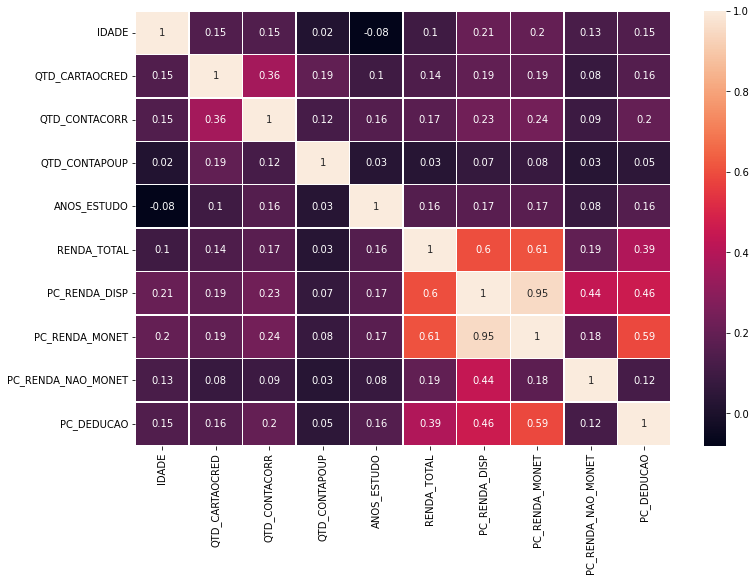

In [439]:
plt.subplots(figsize=(12, 8))
sns.heatmap(df_superior[quant_vars].corr().round(2), annot=True, linewidths=.5);

Remover a variável PC_RENDA_MONET porque ela possui alta correlação com a PC_RENDA_DISP

In [440]:
df_superior.drop('PC_RENDA_MONET', axis=1, inplace=True)

df_superior.shape

(27543, 29)

In [441]:
quant_vars = ['IDADE','QTD_CARTAOCRED', 'QTD_CONTACORR','QTD_CONTAPOUP', 'ANOS_ESTUDO', 'RENDA_TOTAL', 
              'PC_RENDA_DISP', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO']

#### Medidas de Posição

In [442]:
med_posicao_dispersao = df_superior[quant_vars].describe().round(2)

med_posicao_dispersao

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
count,27543.00,25741.00,25741.00,25741.00,27543.00,27543.00,27543.00,27543.00,27543.00
mean,38.75,0.58,0.65,0.51,12.68,5830.73,1744.27,383.52,165.35
std,13.93,0.83,0.61,0.56,1.31,9300.43,2019.49,585.73,337.01
min,17.00,0.00,0.00,0.00,12.00,8.38,-1343.45,0.00,0.00
25%,28.00,0.00,0.00,0.00,12.00,2465.16,808.60,146.30,25.51
50%,37.00,0.00,1.00,0.00,12.00,4117.86,1300.39,271.92,72.39
75%,48.00,1.00,1.00,1.00,13.00,6779.68,2061.02,475.22,170.97
max,97.00,12.00,6.00,5.00,16.00,672890.96,70587.33,42379.41,11563.75


#### Medidas de Dispersão

##### Amplitude

In [443]:
Amplitude = pd.DataFrame(med_posicao_dispersao.loc['max'] - med_posicao_dispersao.loc['min']).T

lst_index = ['Amplitude']

Amplitude.index = lst_index

Amplitude

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
Amplitude,80.0,12.0,6.0,5.0,4.0,672882.58,71930.78,42379.41,11563.75


In [444]:
#adicionando na lista de medidas
med_posicao_dispersao = med_posicao_dispersao.append(Amplitude)

med_posicao_dispersao

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
count,27543.00,25741.00,25741.00,25741.00,27543.00,27543.00,27543.00,27543.00,27543.00
mean,38.75,0.58,0.65,0.51,12.68,5830.73,1744.27,383.52,165.35
std,13.93,0.83,0.61,0.56,1.31,9300.43,2019.49,585.73,337.01
min,17.00,0.00,0.00,0.00,12.00,8.38,-1343.45,0.00,0.00
25%,28.00,0.00,0.00,0.00,12.00,2465.16,808.60,146.30,25.51
50%,37.00,0.00,1.00,0.00,12.00,4117.86,1300.39,271.92,72.39
75%,48.00,1.00,1.00,1.00,13.00,6779.68,2061.02,475.22,170.97
max,97.00,12.00,6.00,5.00,16.00,672890.96,70587.33,42379.41,11563.75
Amplitude,80.00,12.00,6.00,5.00,4.00,672882.58,71930.78,42379.41,11563.75


##### Intervalo Interquartil

In [445]:
interquartil = pd.DataFrame(med_posicao_dispersao.loc['75%'] - med_posicao_dispersao.loc['25%']).T

lst_index = ['Intervalo Interquartil']

interquartil.index = lst_index

interquartil

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
Intervalo Interquartil,20.0,1.0,1.0,1.0,1.0,4314.52,1252.42,328.92,145.46


In [446]:
#adicionando na lista de medidas
med_posicao_dispersao = med_posicao_dispersao.append(interquartil)

med_posicao_dispersao

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
count,27543.00,25741.00,25741.00,25741.00,27543.00,27543.00,27543.00,27543.00,27543.00
mean,38.75,0.58,0.65,0.51,12.68,5830.73,1744.27,383.52,165.35
std,13.93,0.83,0.61,0.56,1.31,9300.43,2019.49,585.73,337.01
min,17.00,0.00,0.00,0.00,12.00,8.38,-1343.45,0.00,0.00
25%,28.00,0.00,0.00,0.00,12.00,2465.16,808.60,146.30,25.51
50%,37.00,0.00,1.00,0.00,12.00,4117.86,1300.39,271.92,72.39
75%,48.00,1.00,1.00,1.00,13.00,6779.68,2061.02,475.22,170.97
max,97.00,12.00,6.00,5.00,16.00,672890.96,70587.33,42379.41,11563.75
Amplitude,80.00,12.00,6.00,5.00,4.00,672882.58,71930.78,42379.41,11563.75
Intervalo Interquartil,20.00,1.00,1.00,1.00,1.00,4314.52,1252.42,328.92,145.46


##### Desvio Padrão

In [447]:
desvpad = pd.DataFrame(med_posicao_dispersao.std()).T

lst_index = ['Desvio Padrão']

desvpad.index = lst_index

desvpad

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
Desvio Padrão,8696.563138,8139.057252,8139.447924,8139.559921,8706.911864,280633.974747,29377.493304,18380.819155,9190.156913


In [448]:
#adicionando na lista de medidas
med_posicao_dispersao = med_posicao_dispersao.append(desvpad)

med_posicao_dispersao

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
count,27543.000000,25741.000000,25741.000000,25741.000000,27543.000000,27543.000000,27543.000000,27543.000000,27543.000000
mean,38.750000,0.580000,0.650000,0.510000,12.680000,5830.730000,1744.270000,383.520000,165.350000
std,13.930000,0.830000,0.610000,0.560000,1.310000,9300.430000,2019.490000,585.730000,337.010000
min,17.000000,0.000000,0.000000,0.000000,12.000000,8.380000,-1343.450000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,12.000000,2465.160000,808.600000,146.300000,25.510000
50%,37.000000,0.000000,1.000000,0.000000,12.000000,4117.860000,1300.390000,271.920000,72.390000
75%,48.000000,1.000000,1.000000,1.000000,13.000000,6779.680000,2061.020000,475.220000,170.970000
max,97.000000,12.000000,6.000000,5.000000,16.000000,672890.960000,70587.330000,42379.410000,11563.750000
Amplitude,80.000000,12.000000,6.000000,5.000000,4.000000,672882.580000,71930.780000,42379.410000,11563.750000
Intervalo Interquartil,20.000000,1.000000,1.000000,1.000000,1.000000,4314.520000,1252.420000,328.920000,145.460000


##### Coeficiente de Variação

In [449]:
cv = pd.DataFrame((med_posicao_dispersao.std()/med_posicao_dispersao.mean())*100).T

lst_index = ['Coeficiente de Variação']

cv.index = lst_index

cv

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
Coeficiente de Variação,253.532788,256.33171,256.427954,256.455506,255.891423,175.789073,149.057616,145.390146,159.321878


In [450]:
#adicionando na lista de medidas
med_posicao_dispersao = med_posicao_dispersao.append(cv)

med_posicao_dispersao

,IDADE,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
count,27543.000000,25741.000000,25741.000000,25741.000000,27543.000000,27543.000000,27543.000000,27543.000000,27543.000000
mean,38.750000,0.580000,0.650000,0.510000,12.680000,5830.730000,1744.270000,383.520000,165.350000
std,13.930000,0.830000,0.610000,0.560000,1.310000,9300.430000,2019.490000,585.730000,337.010000
min,17.000000,0.000000,0.000000,0.000000,12.000000,8.380000,-1343.450000,0.000000,0.000000
25%,28.000000,0.000000,0.000000,0.000000,12.000000,2465.160000,808.600000,146.300000,25.510000
50%,37.000000,0.000000,1.000000,0.000000,12.000000,4117.860000,1300.390000,271.920000,72.390000
75%,48.000000,1.000000,1.000000,1.000000,13.000000,6779.680000,2061.020000,475.220000,170.970000
max,97.000000,12.000000,6.000000,5.000000,16.000000,672890.960000,70587.330000,42379.410000,11563.750000
Amplitude,80.000000,12.000000,6.000000,5.000000,4.000000,672882.580000,71930.780000,42379.410000,11563.750000
Intervalo Interquartil,20.000000,1.000000,1.000000,1.000000,1.000000,4314.520000,1252.420000,328.920000,145.460000


#### Exporta para Excel

In [451]:
# med_posicao_dispersao.to_excel(f'/content/drive/MyDrive/Pós Graduação/TCC/Projeto/arq_exploratoria/univariada_med_posicao_dispersao.xlsx')
# med_posicao_dispersao.to_excel(f'E:/Google Drive/Pós Graduação/TCC/Projeto/arq_exploratoria/univariada_med_posicao_dispersao.xlsx')

#### Boxplot e Histograma

IDADE

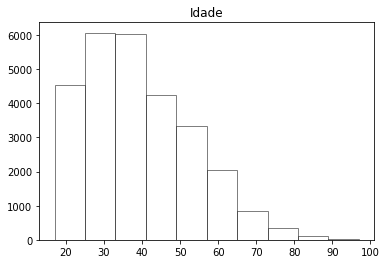

In [452]:
df_superior['IDADE'].hist(bins=10, alpha=0.5, color='white', grid=False, edgecolor='black', linewidth=1)
plt.title('Idade');

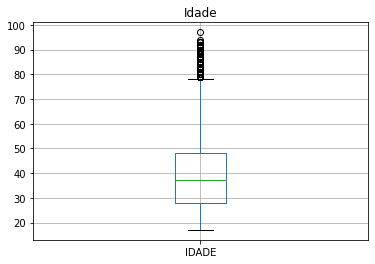

In [453]:
df_superior.boxplot(column='IDADE');
plt.title('Idade');



---



QTD_CARTAOCRED

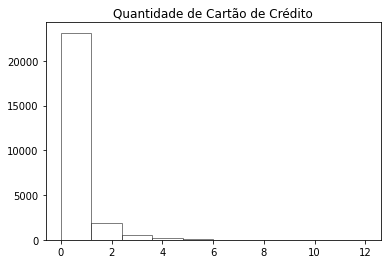

In [454]:
df_superior['QTD_CARTAOCRED'].hist(bins=10, alpha=0.5, color='white', grid=False, edgecolor='black', linewidth=1)
plt.title('Quantidade de Cartão de Crédito');

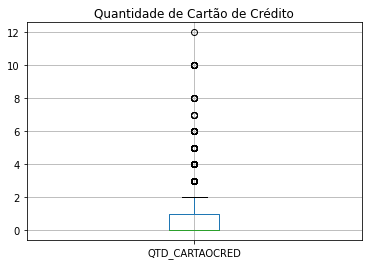

In [455]:
df_superior.boxplot(column='QTD_CARTAOCRED')
plt.title('Quantidade de Cartão de Crédito');



---



QTD_CONTACORR

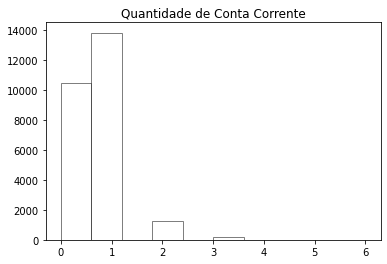

In [456]:
df_superior['QTD_CONTACORR'].hist(bins=10, alpha=0.5, color='white', grid=False, edgecolor='black', linewidth=1)
plt.title('Quantidade de Conta Corrente');

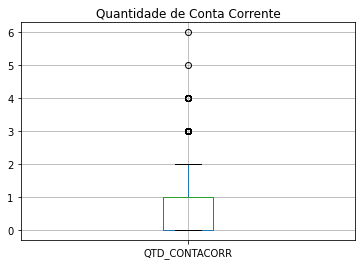

In [457]:
df_superior.boxplot(column='QTD_CONTACORR')
plt.title('Quantidade de Conta Corrente');



---



QTD_CONTAPOUP

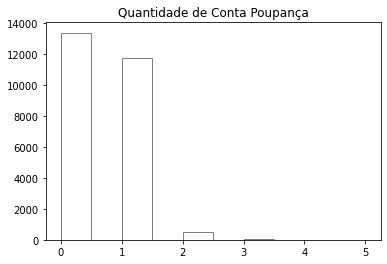

In [458]:
df_superior['QTD_CONTAPOUP'].hist(bins=10, alpha=0.5, color='white', grid=False, edgecolor='black', linewidth=1)
plt.title('Quantidade de Conta Poupança');

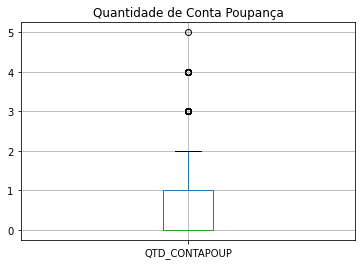

In [459]:
df_superior.boxplot(column='QTD_CONTAPOUP')
plt.title('Quantidade de Conta Poupança');



---



ANOS_ESTUDO

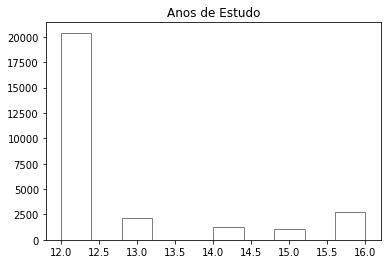

In [460]:
df_superior['ANOS_ESTUDO'].hist(bins=10, alpha=0.5, color='white', grid=False, edgecolor='black', linewidth=1)
plt.title('Anos de Estudo');

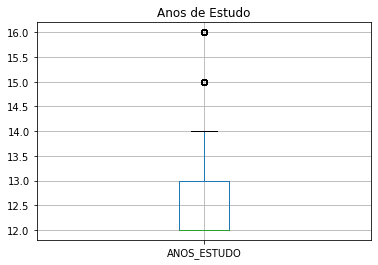

In [461]:
df_superior.boxplot(column='ANOS_ESTUDO')
plt.title('Anos de Estudo');



---



RENDA_TOTAL

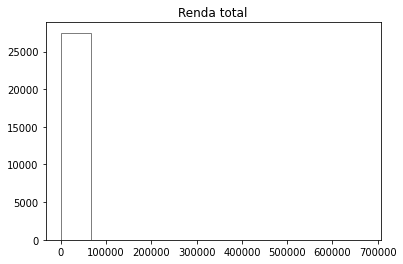

In [462]:
df_superior['RENDA_TOTAL'].hist(bins=10, alpha=0.5, color='white', grid=False, edgecolor='black', linewidth=1)
plt.title('Renda total');

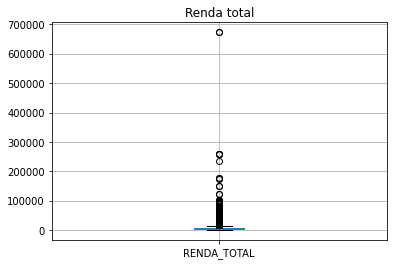

In [463]:
df_superior.boxplot(column='RENDA_TOTAL')
plt.title('Renda total');



---



PC_RENDA_DISP

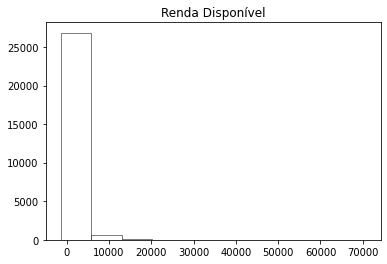

In [464]:
df_superior['PC_RENDA_DISP'].hist(bins=10, alpha=0.5, color='white', grid=False, edgecolor='black', linewidth=1)
plt.title('Renda Disponível');

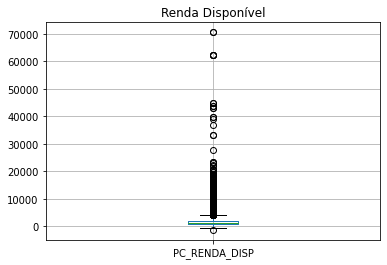

In [465]:
df_superior.boxplot(column='PC_RENDA_DISP')
plt.title('Renda Disponível');



---



PC_RENDA_NAO_MONET

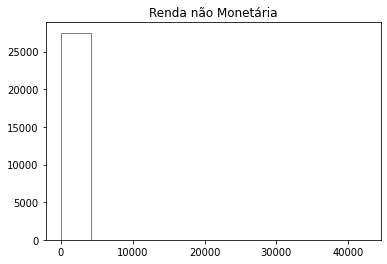

In [466]:
df_superior['PC_RENDA_NAO_MONET'].hist(bins=10, alpha=0.5, color='white', grid=False, edgecolor='black', linewidth=1)
plt.title('Renda não Monetária');

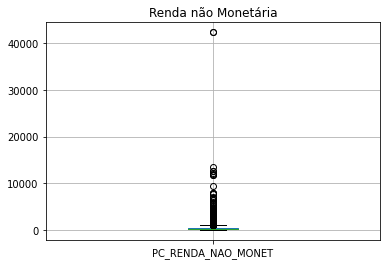

In [467]:
df_superior.boxplot(column='PC_RENDA_NAO_MONET')
plt.title('Renda não Monetária');



---



PC_DEDUCAO

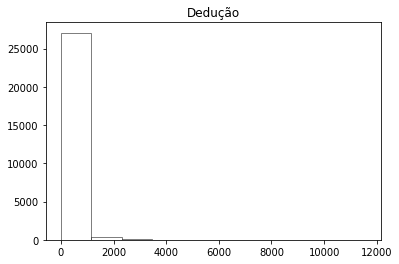

In [468]:
df_superior['PC_DEDUCAO'].hist(bins=10, alpha=0.5, color='white', grid=False, edgecolor='black', linewidth=1)
plt.title('Dedução');

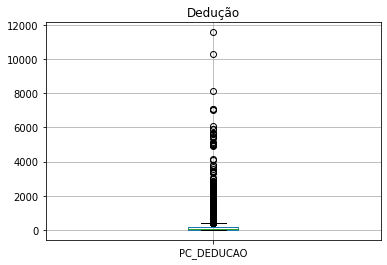

In [469]:
df_superior.boxplot(column='PC_DEDUCAO')
plt.title('Dedução');

## Bivariada

In [470]:
df_superior.columns

Index(['TIPO_SITUACAO_REG', 'COD_UPA', 'NUM_DOM', 'NUM_UC', 'COD_INFORMANTE',
       'IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'JA_FREQ_ESCOLA', 'CONC_CURSO_ANT', 'ANOS_ESTUDO', 'RENDA_TOTAL',
       'PC_RENDA_DISP', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO', 'INSTRUCAO', 'UF',
       'ESTRATO_POF', 'COR_RACA', 'CURSO_MAIS_ELEVADO_ANT',
       'CONC_1PERIODO_CURSO_ANT', 'ULT_PERIODO_CONC_CURSO_ANT', 'COMPOSICAO',
       'FREQ_GRADUACAO'],
      dtype='object')

### Qualitativas

In [471]:
quali_vars = ['TIPO_SITUACAO_REG', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M', 'GASTOS_SEM_RENDA', 
              'JA_FREQ_ESCOLA', 'CONC_CURSO_ANT', 'INSTRUCAO', 'UF', 'ESTRATO_POF', 'COR_RACA', 'CURSO_MAIS_ELEVADO_ANT',
              'CONC_1PERIODO_CURSO_ANT', 'ULT_PERIODO_CONC_CURSO_ANT', 'COMPOSICAO']

#### Exporta para Excel

In [472]:
def export_tab_cruzada(df, lista_var):
    for var in lista_var:
        pd.crosstab(df_superior[var], df_superior["FREQ_GRADUACAO"], normalize='index').to_excel(f'/content/drive/MyDrive/Pós Graduação/TCC/Projeto/arq_exploratoria/bivariada_{var}.xlsx')
        #pd.crosstab(df_superior[var], df_superior["FREQ_GRADUACAO"], normalize='index').to_excel(f'E:/Google Drive/Pós Graduação/TCC/Projeto/arq_exploratoria/bivariada_{var}.xlsx')

In [473]:
# export_tab_cruzada(df_superior, quali_vars)

#### Tabela Cruzada

In [474]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["TIPO_SITUACAO_REG"])

TIPO_SITUACAO_REG,Rural,Urbano
FREQ_GRADUACAO,,
0,2466,22129
1,165,2783


In [475]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["TIPO_SITUACAO_REG"], normalize='columns').round(2)

TIPO_SITUACAO_REG,Rural,Urbano
FREQ_GRADUACAO,,
0,0.94,0.89
1,0.06,0.11


Analisando variável TIPO_SITUACAO_REG vejo que ela é um resumo da variável ESTRATO_POF. Melhor retirar.

In [476]:
pd.crosstab(df_superior["ESTRATO_POF"], df_superior["TIPO_SITUACAO_REG"], normalize=True, dropna = False).round(2)

TIPO_SITUACAO_REG,Rural,Urbano
ESTRATO_POF,,
Rural,0.1,0.00
Urbano - Capital,0.0,0.30
Urbano - Demais,0.0,0.43
Urbano - Regiao Metropolitana,0.0,0.18


In [477]:
df_superior.drop('TIPO_SITUACAO_REG', axis = 1, inplace=True)

df_superior.shape

(27543, 28)



---



In [478]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["SEXO_M"])

SEXO_M,0,1
FREQ_GRADUACAO,,
0,13000,11595
1,1682,1266


In [479]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["SEXO_M"], normalize='columns').round(2)

SEXO_M,0,1
FREQ_GRADUACAO,,
0,0.89,0.9
1,0.11,0.1




---



In [480]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["TEM_PLANO_SAUDE"])

TEM_PLANO_SAUDE,0,1
FREQ_GRADUACAO,,
0,16891,7704
1,1861,1087


In [481]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["TEM_PLANO_SAUDE"], normalize='columns').round(2)

TEM_PLANO_SAUDE,0,1
FREQ_GRADUACAO,,
0,0.9,0.88
1,0.1,0.12




---



In [482]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["TRABALHOU_ULT_12M"])

TRABALHOU_ULT_12M,0.0,1.0
FREQ_GRADUACAO,,
0,2735,21106
1,617,2147


In [483]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["TRABALHOU_ULT_12M"], normalize='columns').round(2)

TRABALHOU_ULT_12M,0.0,1.0
FREQ_GRADUACAO,,
0,0.82,0.91
1,0.18,0.09




---



In [484]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["GASTOS_SEM_RENDA"])

GASTOS_SEM_RENDA,0.0,1.0
FREQ_GRADUACAO,,
0,734,23107
1,130,2634


In [485]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["GASTOS_SEM_RENDA"], normalize='columns').round(2)

GASTOS_SEM_RENDA,0.0,1.0
FREQ_GRADUACAO,,
0,0.85,0.9
1,0.15,0.1




---



In [486]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["QTD_CARTAOCRED"])

QTD_CARTAOCRED,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,12.0
FREQ_GRADUACAO,,,,,,,,,,,
0,13029,7671,1714,479,138,45,13,4,5,8,1
1,1500,936,149,37,8,2,1,0,1,0,0


In [487]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["QTD_CARTAOCRED"], normalize='columns').round(2)

QTD_CARTAOCRED,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,12.0
FREQ_GRADUACAO,,,,,,,,,,,
0,0.9,0.89,0.92,0.93,0.95,0.96,0.93,1.0,0.83,1.0,1.0
1,0.1,0.11,0.08,0.07,0.05,0.04,0.07,0.0,0.17,0.0,0.0




---



In [488]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["QTD_CONTACORR"])

QTD_CONTACORR,0.0,1.0,2.0,3.0,4.0,5.0,6.0
FREQ_GRADUACAO,,,,,,,
0,9545,12336,1064,143,17,1,1
1,952,1500,166,16,0,0,0


In [489]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["QTD_CONTACORR"], normalize='columns').round(2)

QTD_CONTACORR,0.0,1.0,2.0,3.0,4.0,5.0,6.0
FREQ_GRADUACAO,,,,,,,
0,0.91,0.89,0.87,0.9,1.0,1.0,1.0
1,0.09,0.11,0.13,0.1,0.0,0.0,0.0




---



In [490]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["QTD_CONTAPOUP"])

QTD_CONTAPOUP,0.0,1.0,2.0,3.0,4.0,5.0
FREQ_GRADUACAO,,,,,,
0,12038,10524,473,61,10,1
1,1351,1218,54,9,2,0


In [491]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["QTD_CONTAPOUP"], normalize='columns').round(2)

QTD_CONTAPOUP,0.0,1.0,2.0,3.0,4.0,5.0
FREQ_GRADUACAO,,,,,,
0,0.9,0.9,0.9,0.87,0.83,1.0
1,0.1,0.1,0.1,0.13,0.17,0.0


---

Analisando variável `JA_FREQ_ESCOLA`, ela só está preenchida quando `FREQ_GRADUACAO` == 0. Melhor retirar.

In [492]:
pd.crosstab(df_superior["JA_FREQ_ESCOLA"], df_superior["FREQ_GRADUACAO"], normalize=True, dropna = False).round(2)

FREQ_GRADUACAO,0,1
JA_FREQ_ESCOLA,,
1.0,1.0,0.0


In [493]:
df_superior.drop('JA_FREQ_ESCOLA', axis = 1, inplace=True)

df_superior.shape

(27543, 27)

---

In [494]:
df_superior['CONC_CURSO_ANT'].isna().sum()

3390

Analisando variável `CONC_CURSO_ANT`, ela só está preenchida quando `FREQ_GRADUACAO` == 0. Melhor retirar.

In [495]:
pd.crosstab(df_superior["CONC_CURSO_ANT"], df_superior["FREQ_GRADUACAO"], normalize=True, dropna = False).round(2)

FREQ_GRADUACAO,0,1
CONC_CURSO_ANT,,
0.0,0.08,0.0
1.0,0.92,0.0


In [496]:
df_superior.drop('CONC_CURSO_ANT', axis=1, inplace=True)

df_superior.shape

(27543, 26)



---



In [497]:
pd.crosstab(df_superior["CURSO_MAIS_ELEVADO_ANT"], df_superior["FREQ_GRADUACAO"], normalize=True, dropna = False).round(2)

FREQ_GRADUACAO,0,1
CURSO_MAIS_ELEVADO_ANT,,
"Antigo científico, clássico, etc. (médio 2º ciclo)",0.04,0.0
Doutorado,0.00,0.0
Educação de jovens e adultos – EJA do ensino médio ou supletivo do 2º grau,0.03,0.0
Especialização de nível superior (duração mínima de 360 horas),0.02,0.0
Mestrado,0.00,0.0
Regular do ensino médio ou do 2º grau,0.75,0.0
Superior – graduação,0.16,0.0


Analisando variável `CURSO_MAIS_ELEVADO_ANT`, ela só está preenchida quando `FREQ_GRADUACAO` == 0. Melhor retirar.

In [498]:
df_superior.drop('CURSO_MAIS_ELEVADO_ANT', axis=1, inplace=True)

df_superior.shape

(27543, 25)



---



In [499]:
pd.crosstab(df_superior["CONC_1PERIODO_CURSO_ANT"], df_superior["FREQ_GRADUACAO"], normalize=True, dropna = False).round(2)

FREQ_GRADUACAO,0,1
CONC_1PERIODO_CURSO_ANT,,
Curso não classificado em séries ou anos,0.00,0.0
Não,0.01,0.0
Sim,0.99,0.0


Analisando variável `CONC_1PERIODO_CURSO_ANT`, ela só está preenchida quando `FREQ_GRADUACAO` == 0. Melhor retirar.

In [500]:
df_superior.drop('CONC_1PERIODO_CURSO_ANT', axis=1, inplace=True)

df_superior.shape

(27543, 24)



---



In [501]:
df_superior['ULT_PERIODO_CONC_CURSO_ANT'].isna().sum()

3823

In [502]:
pd.crosstab(df_superior["ULT_PERIODO_CONC_CURSO_ANT"], df_superior["FREQ_GRADUACAO"], normalize=True, dropna = False).round(2)

FREQ_GRADUACAO,0,1
ULT_PERIODO_CONC_CURSO_ANT,,
Décimo,0.02,0.0
Décimo primeiro,0.00,0.0
Décimo segundo,0.00,0.0
Nona(o),0.00,0.0
Oitava(o),0.04,0.0
Primeira(o),0.01,0.0
Quarta(o),0.05,0.0
Quinta(o),0.01,0.0
Segunda(o),0.02,0.0


Analisando variável `ULT_PERIODO_CONC_CURSO_ANT`, a grande maioria dos casos são quando `FREQ_GRADUACAO` == 0. Melhor retirar.

In [503]:
df_superior.drop('ULT_PERIODO_CONC_CURSO_ANT', axis=1, inplace=True)

df_superior.shape

(27543, 23)



---



In [504]:
pd.crosstab(df_superior['INSTRUCAO'], df_superior["ANOS_ESTUDO"])

ANOS_ESTUDO,12,13,14,15,16
INSTRUCAO,,,,,
Ensino Médio Completo,19708,1312,531,521,2023
Ensino Superior Incompleto,709,802,720,532,685


In [505]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["ANOS_ESTUDO"])

ANOS_ESTUDO,12,13,14,15,16
FREQ_GRADUACAO,,,,,
0,19643,1435,673,465,2379
1,774,679,578,588,329


In [506]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["ANOS_ESTUDO"], normalize='columns').round(2)

ANOS_ESTUDO,12,13,14,15,16
FREQ_GRADUACAO,,,,,
0,0.96,0.68,0.54,0.44,0.88
1,0.04,0.32,0.46,0.56,0.12




---



In [507]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["UF"])

UF,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
FREQ_GRADUACAO,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,431,535,1066,404,1299,1095,671,1382,833,859,1642,615,605,672,618,1381,678,1219,1825,594,304,489,1131,1005,644,2218,380
1,82,81,126,72,136,107,109,143,78,97,176,80,108,80,94,146,90,146,154,70,51,66,167,138,88,209,54


In [508]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["UF"], normalize='columns').round(2)

UF,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,MG,MS,MT,PA,PB,PE,PI,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
FREQ_GRADUACAO,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.84,0.87,0.89,0.85,0.91,0.91,0.86,0.91,0.91,0.9,0.9,0.88,0.85,0.89,0.87,0.9,0.88,0.89,0.92,0.89,0.86,0.88,0.87,0.88,0.88,0.91,0.88
1,0.16,0.13,0.11,0.15,0.09,0.09,0.14,0.09,0.09,0.1,0.1,0.12,0.15,0.11,0.13,0.1,0.12,0.11,0.08,0.11,0.14,0.12,0.13,0.12,0.12,0.09,0.12




---



In [509]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["ESTRATO_POF"])

ESTRATO_POF,Rural,Urbano - Capital,Urbano - Demais,Urbano - Regiao Metropolitana
FREQ_GRADUACAO,,,,
0,2466,7251,10526,4352
1,165,1007,1267,509


In [510]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["ESTRATO_POF"], normalize='columns').round(2)

ESTRATO_POF,Rural,Urbano - Capital,Urbano - Demais,Urbano - Regiao Metropolitana
FREQ_GRADUACAO,,,,
0,0.94,0.88,0.89,0.9
1,0.06,0.12,0.11,0.1




---



In [511]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["COR_RACA"])

COR_RACA,Amarela,Branca,Indígena,Parda,Preta,Sem declaração
FREQ_GRADUACAO,,,,,,
0,135,10252,109,11462,2607,30
1,20,1327,12,1293,292,4


In [512]:
pd.crosstab(df_superior['FREQ_GRADUACAO'], df_superior["COR_RACA"], normalize='columns').round(2)

COR_RACA,Amarela,Branca,Indígena,Parda,Preta,Sem declaração
FREQ_GRADUACAO,,,,,,
0,0.87,0.89,0.9,0.9,0.9,0.88
1,0.13,0.11,0.1,0.1,0.1,0.12


---

In [513]:
pd.crosstab(df_superior['COMPOSICAO'], df_superior["FREQ_GRADUACAO"])

FREQ_GRADUACAO,0,1
COMPOSICAO,,
Mais de um adulto com ao menos uma criança,10686,1021
Mais de um adulto sem criança,8975,1490
Um adulto com ao menos uma criança,569,44
Um adulto sem criança,1236,159
Um ou mais idosos com ou sem crianças,536,4
"Um ou mais idosos, com ao menos um adulto, com ou sem crianças",2593,230


In [514]:
pd.crosstab(df_superior['COMPOSICAO'], df_superior["FREQ_GRADUACAO"], normalize='columns').round(2)

FREQ_GRADUACAO,0,1
COMPOSICAO,,
Mais de um adulto com ao menos uma criança,0.43,0.35
Mais de um adulto sem criança,0.36,0.51
Um adulto com ao menos uma criança,0.02,0.01
Um adulto sem criança,0.05,0.05
Um ou mais idosos com ou sem crianças,0.02,0.00
"Um ou mais idosos, com ao menos um adulto, com ou sem crianças",0.11,0.08




---



### Quantitativas

IDADE

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

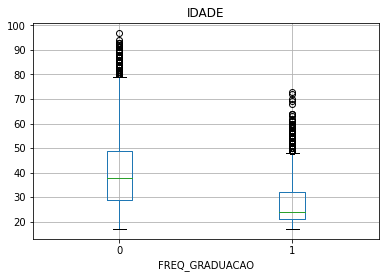

In [515]:
df_superior.boxplot(column='IDADE', by='FREQ_GRADUACAO')
plt.suptitle('')

----------------------------------------------------------------------

QTD_CARTAOCRED

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

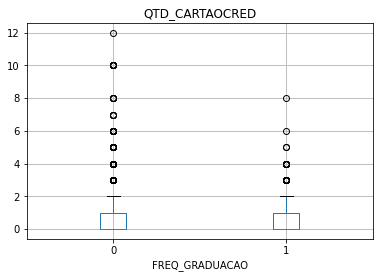

In [516]:
df_superior.boxplot(column='QTD_CARTAOCRED', by='FREQ_GRADUACAO')
plt.suptitle('')



---



QTD_CONTACORR

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

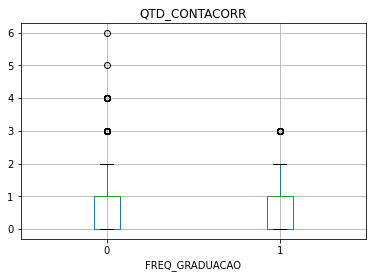

In [517]:
df_superior.boxplot(column='QTD_CONTACORR', by='FREQ_GRADUACAO')
plt.suptitle('')



---



QTD_CONTAPOUP

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

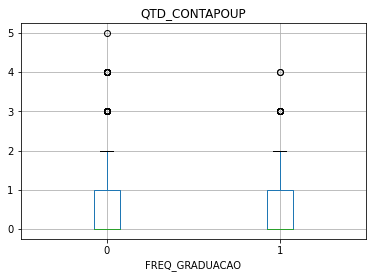

In [518]:
df_superior.boxplot(column='QTD_CONTAPOUP', by='FREQ_GRADUACAO')
plt.suptitle('')



---



ANOS_ESTUDO

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

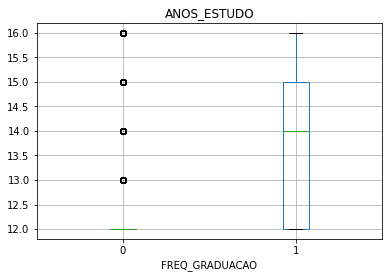

In [519]:
df_superior.boxplot(column='ANOS_ESTUDO', by='FREQ_GRADUACAO')
plt.suptitle('')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

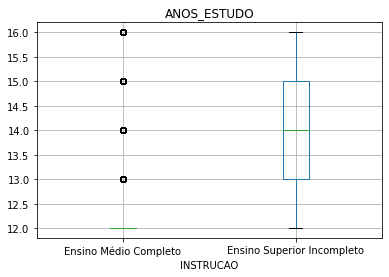

In [520]:
df_superior.boxplot(column='ANOS_ESTUDO', by='INSTRUCAO')
plt.suptitle('')

Analisando variável `ANOS_ESTUDO`, vejo que tem uma correlação com a `INSTRUCAO`. Melhor retirar a `INSTRUCAO` .

In [521]:
df_superior.drop('INSTRUCAO', axis=1, inplace=True)

df_superior.shape

(27543, 22)



---



RENDA_TOTAL

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

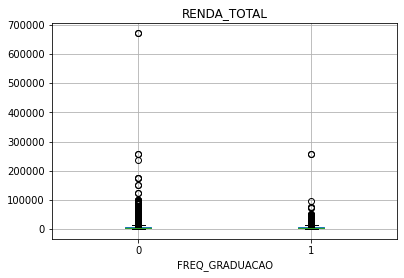

In [522]:
df_superior.boxplot(column='RENDA_TOTAL', by='FREQ_GRADUACAO')
plt.suptitle('')



---



PC_RENDA_DISP

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

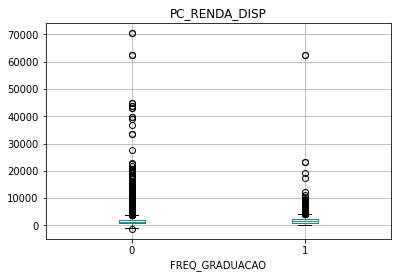

In [523]:
df_superior.boxplot(column='PC_RENDA_DISP', by='FREQ_GRADUACAO')
plt.suptitle('')



---



PC_RENDA_NAO_MONET

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

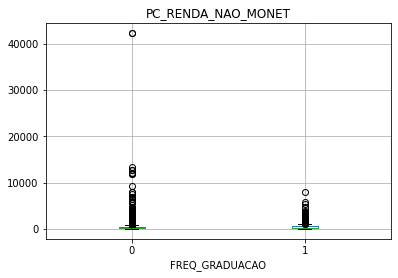

In [524]:
df_superior.boxplot(column='PC_RENDA_NAO_MONET', by='FREQ_GRADUACAO')
plt.suptitle('')



---



PC_DEDUCAO

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, '')

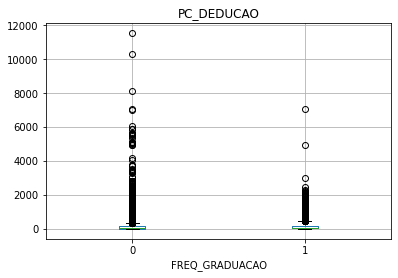

In [525]:
df_superior.boxplot(column='PC_DEDUCAO', by='FREQ_GRADUACAO')
plt.suptitle('')

# Modelo

## Identificar variáveis do modelo

In [526]:
df_superior.head()

,COD_UPA,NUM_DOM,NUM_UC,COD_INFORMANTE,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO,UF,ESTRATO_POF,COR_RACA,COMPOSICAO,FREQ_GRADUACAO
3,110000016,3,1,1,37,0,0,1.0,1.0,0.0,1.0,1.0,12,4242.48,1263.141667,446.340417,9.978750,RO,Urbano - Capital,Parda,Mais de um adulto com ao menos uma criança,0
9,110000016,5,1,1,45,0,1,1.0,1.0,1.0,1.0,1.0,12,12943.65,1965.761000,553.433500,179.442333,RO,Urbano - Capital,Parda,Mais de um adulto com ao menos uma criança,0
10,110000016,5,1,2,30,1,1,1.0,1.0,1.0,1.0,1.0,12,12943.65,1965.761000,553.433500,179.442333,RO,Urbano - Capital,Branca,Mais de um adulto com ao menos uma criança,0
11,110000016,5,1,3,24,0,0,1.0,1.0,0.0,1.0,0.0,12,12943.65,1965.761000,553.433500,179.442333,RO,Urbano - Capital,Parda,Mais de um adulto com ao menos uma criança,0
14,110000016,7,1,1,37,1,0,1.0,1.0,4.0,1.0,1.0,12,6253.24,1083.508556,233.708833,176.471389,RO,Urbano - Capital,Parda,Mais de um adulto com ao menos uma criança,0


In [527]:
df_superior.columns

Index(['COD_UPA', 'NUM_DOM', 'NUM_UC', 'COD_INFORMANTE', 'IDADE', 'SEXO_M',
       'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M', 'GASTOS_SEM_RENDA',
       'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP', 'ANOS_ESTUDO',
       'RENDA_TOTAL', 'PC_RENDA_DISP', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO',
       'UF', 'ESTRATO_POF', 'COR_RACA', 'COMPOSICAO', 'FREQ_GRADUACAO'],
      dtype='object')

In [528]:
df_superior.shape

(27543, 22)

In [529]:
key_vars = ['COD_UPA', 'NUM_DOM', 'NUM_UC', 'COD_INFORMANTE']

num_vars = ['IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M', 'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 
            'QTD_CONTAPOUP', 'ANOS_ESTUDO', 'RENDA_TOTAL', 'PC_RENDA_DISP', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO']

cat_vars = ['UF', 'ESTRATO_POF', 'COR_RACA', 'COMPOSICAO']

target = 'FREQ_GRADUACAO'

lst_target = ['FREQ_GRADUACAO']

features = cat_vars + num_vars

model_var = features + lst_target

In [530]:
df_abt = df_superior[model_var]

df_abt.shape

(27543, 18)

## Separando em treino e teste

In [531]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_abt[features], df_abt[target], train_size = 0.8, random_state = 42)

In [532]:
type(X_train), type(y_train), type(X_test), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series)

In [533]:
X_train.shape

(22034, 17)

In [534]:
y_train.shape

(22034,)

In [535]:
X_test.shape

(5509, 17)

In [536]:
y_test.shape

(5509,)

In [537]:
y_train.value_counts(dropna=False, normalize =True).round(2)

0    0.89
1    0.11
Name: FREQ_GRADUACAO, dtype: float64

In [538]:
y_test.value_counts(dropna=False, normalize =True).round(2)

0    0.89
1    0.11
Name: FREQ_GRADUACAO, dtype: float64

## Criando base balanceada

### Inputando Missing

In [539]:
X_train.isnull().sum()

UF                       0
ESTRATO_POF              0
COR_RACA                 0
COMPOSICAO               0
IDADE                    0
SEXO_M                   0
TEM_PLANO_SAUDE          0
TRABALHOU_ULT_12M      750
GASTOS_SEM_RENDA       750
QTD_CARTAOCRED        1452
QTD_CONTACORR         1452
QTD_CONTAPOUP         1452
ANOS_ESTUDO              0
RENDA_TOTAL              0
PC_RENDA_DISP            0
PC_RENDA_NAO_MONET       0
PC_DEDUCAO               0
dtype: int64

In [540]:
#!pip install feature_engine

In [541]:
from feature_engine.imputation import ArbitraryNumberImputer

arbitrary_number = ArbitraryNumberImputer(variables=num_vars, arbitrary_number=-999)

arbitrary_number.fit(X_train)

X_train = arbitrary_number.transform(X_train)
X_test = arbitrary_number.transform(X_test)

In [542]:
X_train.isnull().sum()

UF                    0
ESTRATO_POF           0
COR_RACA              0
COMPOSICAO            0
IDADE                 0
SEXO_M                0
TEM_PLANO_SAUDE       0
TRABALHOU_ULT_12M     0
GASTOS_SEM_RENDA      0
QTD_CARTAOCRED        0
QTD_CONTACORR         0
QTD_CONTAPOUP         0
ANOS_ESTUDO           0
RENDA_TOTAL           0
PC_RENDA_DISP         0
PC_RENDA_NAO_MONET    0
PC_DEDUCAO            0
dtype: int64

### Under Sampling

Random under-sampling:
1    2356
0    2356
Name: FREQ_GRADUACAO, dtype: int64


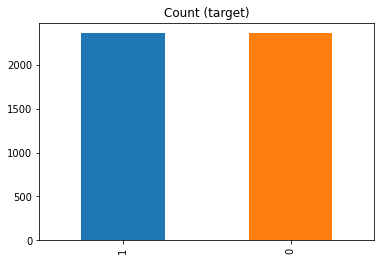

In [543]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

X_train_under = pd.DataFrame(X_train_under, columns=X_train.columns)
y_train_under = pd.Series(y_train_under)
y_train_under.name = "FREQ_GRADUACAO"

print('Random under-sampling:')
print(y_train_under.value_counts())

y_train_under.value_counts().plot(kind='bar', title='Count (target)',color = ['#1F77B4', '#FF7F0E']);

In [544]:
type(X_train_under), type(y_train_under)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [545]:
X_train_under

,UF,ESTRATO_POF,COR_RACA,COMPOSICAO,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
0,PE,Urbano - Demais,Parda,Mais de um adulto com ao menos uma criança,41,1,1,1.0,1.0,1.0,1.0,1.0,16,12908.74,1854.965833,151.335167,218.328500
1,MT,Rural,Parda,Mais de um adulto sem criança,46,0,0,1.0,1.0,1.0,0.0,1.0,12,10306.91,2392.216458,159.833333,107.295278
2,MG,Urbano - Demais,Preta,Mais de um adulto sem criança,42,1,0,1.0,1.0,1.0,1.0,3.0,12,9817.64,2072.217500,523.100278,204.631944
3,MS,Urbano - Capital,Parda,Mais de um adulto com ao menos uma criança,34,0,0,1.0,1.0,0.0,1.0,0.0,14,4348.22,648.227917,198.303889,64.180694
4,DF,Urbano - Regiao Metropolitana,Parda,Mais de um adulto sem criança,33,1,1,1.0,1.0,0.0,0.0,1.0,12,7152.24,1439.426875,374.184375,270.858542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,PA,Rural,Parda,Mais de um adulto com ao menos uma criança,48,0,0,1.0,1.0,1.0,2.0,2.0,13,2371.00,375.285972,85.236111,19.880139
4708,RS,Urbano - Demais,Branca,"Um ou mais idosos, com ao menos um adulto, com...",23,0,1,1.0,1.0,0.0,1.0,0.0,13,4298.00,1458.753333,434.241944,45.862500
4709,SE,Urbano - Regiao Metropolitana,Parda,Mais de um adulto com ao menos uma criança,22,0,1,1.0,1.0,3.0,1.0,2.0,12,8882.84,1216.637546,202.456667,125.675648
4710,SE,Urbano - Capital,Preta,"Um ou mais idosos, com ao menos um adulto, com...",35,1,1,1.0,1.0,2.0,1.0,1.0,16,26136.34,4779.504167,580.036458,1745.802708


In [546]:
y_train_under

0       0
1       0
2       0
3       0
4       0
       ..
4707    1
4708    1
4709    1
4710    1
4711    1
Name: FREQ_GRADUACAO, Length: 4712, dtype: int64

In [547]:
df_train_balanceada = pd.concat([X_train_under, y_train_under], axis=1)

df_train_balanceada.shape

(4712, 18)

In [548]:
df_train_balanceada.head()

,UF,ESTRATO_POF,COR_RACA,COMPOSICAO,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO,FREQ_GRADUACAO
0,PE,Urbano - Demais,Parda,Mais de um adulto com ao menos uma criança,41,1,1,1.0,1.0,1.0,1.0,1.0,16,12908.74,1854.965833,151.335167,218.328500,0
1,MT,Rural,Parda,Mais de um adulto sem criança,46,0,0,1.0,1.0,1.0,0.0,1.0,12,10306.91,2392.216458,159.833333,107.295278,0
2,MG,Urbano - Demais,Preta,Mais de um adulto sem criança,42,1,0,1.0,1.0,1.0,1.0,3.0,12,9817.64,2072.217500,523.100278,204.631944,0
3,MS,Urbano - Capital,Parda,Mais de um adulto com ao menos uma criança,34,0,0,1.0,1.0,0.0,1.0,0.0,14,4348.22,648.227917,198.303889,64.180694,0
4,DF,Urbano - Regiao Metropolitana,Parda,Mais de um adulto sem criança,33,1,1,1.0,1.0,0.0,0.0,1.0,12,7152.24,1439.426875,374.184375,270.858542,0


In [549]:
df_train_balanceada[target].value_counts(dropna=False, normalize =True).round(2)

1    0.5
0    0.5
Name: FREQ_GRADUACAO, dtype: float64

In [550]:
df_test = pd.concat([X_test, y_test], axis=1)

df_test.shape

(5509, 18)

In [551]:
df_test[target].value_counts(dropna=False, normalize =True).round(2)

0    0.89
1    0.11
Name: FREQ_GRADUACAO, dtype: float64

## Regressão Logística (Statsmodel)

In [552]:
import statsmodels.api as sm

### Feature Scaling

Base de Treino

In [553]:
X_train_under[num_vars].describe()

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
count,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000,4712.000000
mean,34.020374,0.449278,0.338285,-45.424024,-45.303480,-84.295628,-84.189092,-84.334253,13.098472,6002.858994,1815.787650,417.180272,171.639674
std,13.426230,0.497473,0.473176,210.045681,210.072006,278.624291,278.656392,278.612082,1.405202,7332.101780,1926.253061,481.391976,323.937691
min,17.000000,0.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,12.000000,8.380000,-788.519167,0.000000,0.000000
25%,23.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,12.000000,2592.310000,884.721979,155.894531,27.911094
50%,31.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,12.000000,4314.190000,1383.243368,301.245694,77.208444
75%,42.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,7017.840000,2173.634010,521.848125,184.420653
max,92.000000,1.000000,1.000000,1.000000,1.000000,8.000000,5.000000,4.000000,16.000000,257432.450000,62424.025347,11787.718333,7065.710833


In [554]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_under[num_vars])

X_train_scale= pd.DataFrame(scaler.transform(X_train_under[num_vars]), columns=num_vars)
X_train_scale.describe()

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
count,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03,4.712000e+03
mean,2.040742e-15,1.423215e-15,-3.272331e-15,1.912837e-15,-2.161884e-15,2.421073e-16,1.065715e-15,-1.365207e-15,-8.138250e-15,-1.346664e-16,-9.538328e-17,-9.090069e-17,-7.116195e-17
std,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00
min,-1.267830e+00,-9.032163e-01,-7.150001e-01,-4.540332e+00,-4.540337e+00,-3.283280e+00,-3.283284e+00,-3.283285e+00,-7.818010e-01,-8.176530e-01,-1.352150e+00,-8.667044e-01,-5.299102e-01
25%,-8.208964e-01,-9.032163e-01,-7.150001e-01,2.210422e-01,2.204406e-01,3.025744e-01,3.021572e-01,3.027263e-01,-7.818010e-01,-4.652023e-01,-4.834071e-01,-5.428289e-01,-4.437391e-01
50%,-2.249845e-01,-9.032163e-01,-7.150001e-01,2.210422e-01,2.204406e-01,3.025744e-01,3.057462e-01,3.027263e-01,-7.818010e-01,-2.303362e-01,-2.245760e-01,-2.408575e-01,-2.915414e-01
75%,5.943942e-01,1.107155e+00,1.398601e+00,2.210422e-01,2.204406e-01,3.061638e-01,3.057462e-01,3.063159e-01,6.416327e-01,1.384444e-01,1.857930e-01,2.174506e-01,3.945924e-02
max,4.318843e+00,1.107155e+00,1.398601e+00,2.210422e-01,2.204406e-01,3.312899e-01,3.201023e-01,3.170847e-01,2.065066e+00,3.429525e+01,3.146766e+01,2.362263e+01,2.128435e+01


Base de Teste

In [555]:
X_test.describe()

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
count,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000
mean,38.687239,0.463787,0.318025,-33.246506,-33.155382,-62.927936,-62.849882,-62.983663,12.680704,5756.927301,1707.195740,393.793528,166.324173
std,13.809315,0.498732,0.465752,181.546842,181.563760,243.838531,243.858244,243.823288,1.322900,7447.248458,1850.701726,916.445504,343.876591
min,17.000000,0.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,12.000000,50.230000,-224.611944,0.000000,0.000000
25%,28.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,12.000000,2483.840000,809.589048,146.555000,26.023333
50%,37.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,12.000000,4194.820000,1306.854167,270.532500,72.329167
75%,48.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,6856.460000,2035.187500,471.962083,170.429722
max,88.000000,1.000000,1.000000,1.000000,1.000000,12.000000,4.000000,5.000000,16.000000,257432.450000,62424.025347,42379.406667,11563.753333


In [556]:
X_test_scale = pd.DataFrame(scaler.transform(X_test[num_vars]), columns=num_vars)
X_test_scale.describe()

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
count,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000,5509.000000
mean,0.347630,0.029167,-0.042822,0.057982,0.057834,0.076698,0.076587,0.076640,-0.297332,-0.033545,-0.056381,-0.048587,-0.016411
std,1.028642,1.002637,0.984413,0.864412,0.864385,0.875245,0.875215,0.875228,0.941530,1.015812,0.960880,1.903943,1.061664
min,-1.267830,-0.903216,-0.715000,-4.540332,-4.540337,-3.283280,-3.283284,-3.283285,-0.781801,-0.811945,-1.059371,-0.866704,-0.529910
25%,-0.448451,-0.903216,-0.715000,0.221042,0.220441,0.302574,0.302157,0.302726,-0.781801,-0.479998,-0.522416,-0.562232,-0.449567
50%,0.221949,-0.903216,-0.715000,0.221042,0.220441,0.302574,0.305746,0.302726,-0.781801,-0.246618,-0.264237,-0.304665,-0.306605
75%,1.041328,1.107155,1.398601,0.221042,0.220441,0.306164,0.305746,0.306316,-0.070084,0.116432,0.113912,0.113811,-0.003736
max,4.020887,1.107155,1.398601,0.221042,0.220441,0.345648,0.316513,0.320674,2.065066,34.295252,31.467657,87.177772,35.171340


### Criando Dummies

In [557]:
from feature_engine.encoding import OneHotEncoder

ohe = OneHotEncoder(variables=cat_vars)

In [558]:
X_train_cat_ohe = ohe.fit_transform(X_train_under[cat_vars])
X_test_cat_ohe  = ohe.transform(X_test[cat_vars])

In [559]:
X_train_cat_ohe.head()

,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0


In [560]:
X_test_cat_ohe.head()

,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
174571,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
145900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
26625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
18353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
85304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


### Reconstruindo as bases de treino e teste

In [561]:
# realinhando os índices das tabelas
X_train_scale = X_train_scale.set_index(X_train_under.index)
X_test_scale  = X_test_scale.set_index(X_test.index)

X_train_cat_ohe = X_train_cat_ohe.set_index(X_train_under.index)
X_test_cat_ohe = X_test_cat_ohe.set_index(X_test.index)

In [562]:
X_train_transformado = pd.concat([X_train_scale, X_train_cat_ohe], axis='columns')
X_train_transformado

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
0,0.519905,1.107155,1.398601,0.221042,0.220441,0.306164,0.305746,0.306316,2.065066,0.941969,0.020341,-0.552301,0.144144,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,0.892350,-0.903216,-0.715000,0.221042,0.220441,0.306164,0.302157,0.306316,-0.781801,0.587077,0.299281,-0.534646,-0.198653,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0.594394,1.107155,-0.715000,0.221042,0.220441,0.306164,0.305746,0.313495,-0.781801,0.520340,0.133138,0.220052,0.101858,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,-0.001518,-0.903216,-0.715000,0.221042,0.220441,0.302574,0.305746,0.302726,0.641633,-0.225694,-0.606194,-0.454722,-0.331763,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
4,-0.076007,1.107155,1.398601,0.221042,0.220441,0.302574,0.302157,0.306316,-0.781801,0.156777,-0.195406,-0.089325,0.306322,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,1.041328,-0.903216,-0.715000,0.221042,0.220441,0.306164,0.309335,0.309905,-0.070084,-0.495389,-0.747905,-0.689624,-0.468533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4708,-0.820896,-0.903216,1.398601,0.221042,0.220441,0.302574,0.305746,0.302726,-0.070084,-0.232544,-0.185371,0.035446,-0.388317,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4709,-0.895385,-0.903216,1.398601,0.221042,0.220441,0.313343,0.305746,0.309905,-0.781801,0.392832,-0.311077,-0.446095,-0.141907,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
4710,0.072971,1.107155,1.398601,0.221042,0.220441,0.309753,0.305746,0.306316,2.065066,2.746227,1.538755,0.338339,4.859978,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [563]:
X_test_transformado = pd.concat([X_test_scale, X_test_cat_ohe], axis='columns')
X_test_transformado

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
174571,-1.044363,1.107155,-0.715000,0.221042,0.220441,0.302574,0.302157,0.306316,-0.781801,-0.508210,0.224176,-0.016399,-0.275763,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
145900,-1.193341,1.107155,-0.715000,0.221042,0.220441,0.302574,0.302157,0.306316,-0.781801,0.714696,0.417904,-0.507877,0.056509,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
26625,-0.597429,-0.903216,-0.715000,0.221042,0.220441,0.302574,0.302157,0.306316,-0.070084,-0.074846,-0.545821,-0.383309,-0.497166,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
18353,0.966839,1.107155,-0.715000,0.221042,0.220441,0.302574,0.305746,0.306316,-0.781801,0.007742,-0.252588,-0.463543,-0.248670,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
85304,1.190306,1.107155,-0.715000,0.221042,0.220441,0.302574,0.302157,0.306316,-0.781801,-0.445329,-0.276005,-0.396030,-0.217255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16026,1.488262,-0.903216,1.398601,0.221042,0.220441,0.306164,0.309335,0.302726,2.065066,0.742102,1.110847,-0.088203,4.923538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
59719,1.637240,1.107155,-0.715000,0.221042,0.220441,0.306164,0.302157,0.306316,-0.781801,0.043082,0.183396,0.167092,-0.496748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
22892,0.519905,1.107155,-0.715000,0.221042,0.220441,0.306164,0.302157,0.306316,-0.781801,-0.420183,-0.454952,-0.661557,-0.394727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
16109,0.892350,1.107155,-0.715000,0.221042,0.220441,0.302574,0.302157,0.306316,-0.781801,0.172024,-0.265023,-0.437710,-0.437812,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


### Rodando uma Regressão Logística

In [564]:
X_train_transformado = sm.add_constant(X_train_transformado)

modelo_sm = sm.Logit(y_train_under,X_train_transformado, random_state=42)

resultados_sm = modelo_sm.fit(maxiter = 1000)

print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.469047
         Iterations 48
                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4659
Method:                           MLE   Df Model:                           52
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3233
Time:                        16:59:52   Log-Likelihood:                -2210.2
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


In [565]:
X_train_transformado.columns

Index(['const', 'IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'RENDA_TOTAL', 'PC_RENDA_DISP', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO', 'UF_PE', 'UF_MT', 'UF_MG', 'UF_MS', 'UF_DF', 'UF_CE',
       'UF_GO', 'UF_RS', 'UF_PR', 'UF_SE', 'UF_RN', 'UF_RJ', 'UF_SP', 'UF_ES',
       'UF_RR', 'UF_PI', 'UF_PB', 'UF_MA', 'UF_BA', 'UF_RO', 'UF_SC', 'UF_PA',
       'UF_TO', 'UF_AC', 'UF_AM', 'UF_AP', 'UF_AL',
       'ESTRATO_POF_Urbano - Demais', 'ESTRATO_POF_Rural',
       'ESTRATO_POF_Urbano - Capital',
       'ESTRATO_POF_Urbano - Regiao Metropolitana', 'COR_RACA_Parda',
       'COR_RACA_Preta', 'COR_RACA_Branca', 'COR_RACA_Amarela',
       'COR_RACA_Indígena', 'COR_RACA_Sem declaração',
       'COMPOSICAO_Mais de um adulto com ao menos uma criança',
       'COMPOSICAO_Mais de um adulto sem criança',
       'COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças',

In [566]:
#Retirando COMPOSICAO por conta do p-value NAN

vars_refinadas = ['const', 'IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'RENDA_TOTAL', 'PC_RENDA_DISP', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO', 'UF_PE', 'UF_MT', 'UF_MG', 'UF_MS',
       'UF_DF', 'UF_CE', 'UF_GO', 'UF_RS', 'UF_PR', 'UF_SE', 'UF_RN', 'UF_RJ',
       'UF_SP', 'UF_ES', 'UF_RR', 'UF_PI', 'UF_PB', 'UF_MA', 'UF_BA', 'UF_RO',
       'UF_SC', 'UF_PA', 'UF_TO', 'UF_AC', 'UF_AM', 'UF_AP', 'UF_AL',
       'ESTRATO_POF_Urbano - Demais', 'ESTRATO_POF_Rural',
       'ESTRATO_POF_Urbano - Capital',
       'ESTRATO_POF_Urbano - Regiao Metropolitana', 'COR_RACA_Parda',
       'COR_RACA_Preta', 'COR_RACA_Branca', 'COR_RACA_Amarela',
       'COR_RACA_Indígena', 'COR_RACA_Sem declaração']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

Optimization terminated successfully.
         Current function value: 0.472124
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4664
Method:                           MLE   Df Model:                           47
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3189
Time:                        16:59:52   Log-Likelihood:                -2224.6
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


In [567]:
#Retirando UF por conta do p-value NAN

vars_refinadas = ['const', 'IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'RENDA_TOTAL', 'PC_RENDA_DISP', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO', 'ESTRATO_POF_Urbano - Demais', 'ESTRATO_POF_Rural',
       'ESTRATO_POF_Urbano - Capital',
       'ESTRATO_POF_Urbano - Regiao Metropolitana', 'COR_RACA_Parda',
       'COR_RACA_Preta', 'COR_RACA_Branca', 'COR_RACA_Amarela',
       'COR_RACA_Indígena', 'COR_RACA_Sem declaração']
       
X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

Optimization terminated successfully.
         Current function value: 0.478572
         Iterations 22
                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4690
Method:                           MLE   Df Model:                           21
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3096
Time:                        16:59:52   Log-Likelihood:                -2255.0
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


In [568]:
#Retirando COR_RACA por conta do p-value > 0.05

vars_refinadas = ['const', 'IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'RENDA_TOTAL', 'PC_RENDA_DISP', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO', 'ESTRATO_POF_Urbano - Demais', 'ESTRATO_POF_Rural',
       'ESTRATO_POF_Urbano - Capital',
       'ESTRATO_POF_Urbano - Regiao Metropolitana']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.478904
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4695
Method:                           MLE   Df Model:                           16
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3091
Time:                        16:59:52   Log-Likelihood:                -2256.6
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


In [569]:
#Retirando ESTRATO_POF por conta do p-value > 0.05

vars_refinadas = ['const', 'IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'RENDA_TOTAL', 'PC_RENDA_DISP', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.481173
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4698
Method:                           MLE   Df Model:                           13
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3058
Time:                        16:59:52   Log-Likelihood:                -2267.3
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0683      0.038     -1.788      0.074      -0.143       0.007
IDADE

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


In [570]:
#Retirando PC_RENDA_DISP por conta do p-value > 0.05

vars_refinadas = ['const', 'IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'RENDA_TOTAL', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.481173
         Iterations 7


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4699
Method:                           MLE   Df Model:                           12
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3058
Time:                        16:59:52   Log-Likelihood:                -2267.3
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0683      0.038     -1.788      0.074      -0.143       0.007
IDADE                 -1.3291      0.050    -26.473      0.000      -1.428      -1.231
SEXO_M              

In [571]:
#Retirando RENDA_TOTAL por conta do p-value > 0.05

vars_refinadas = ['const', 'IDADE', 'SEXO_M', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.481173
         Iterations 7


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4700
Method:                           MLE   Df Model:                           11
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3058
Time:                        16:59:52   Log-Likelihood:                -2267.3
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0683      0.038     -1.790      0.073      -0.143       0.006
IDADE                 -1.3292      0.050    -26.487      0.000      -1.428      -1.231
SEXO_M              

In [572]:
#Retirando SEXO_M por conta do p-value > 0.05

vars_refinadas = ['const', 'IDADE', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CARTAOCRED', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.481199
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4701
Method:                           MLE   Df Model:                           10
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3058
Time:                        16:59:52   Log-Likelihood:                -2267.4
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0679      0.038     -1.780      0.075      -0.143       0.007
IDADE

In [573]:
#Retirando QTD_CARTAOCRED por conta do p-value > 0.05

vars_refinadas = ['const', 'IDADE', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'GASTOS_SEM_RENDA', 'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'PC_RENDA_NAO_MONET', 'PC_DEDUCAO']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.481591
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4702
Method:                           MLE   Df Model:                            9
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3052
Time:                        16:59:52   Log-Likelihood:                -2269.3
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0669      0.038     -1.755      0.079      -0.142       0.008
IDADE

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


### Multicolinearidade (VIF)

In [574]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#PEGUEI ESSE CÓDIGO NA INTERNET
# https://github.com/princebaretto99/removing_multiCollinearity/blob/master/remove_multicolinearity.py

# def get_VIF(dataFrame , target):
#     X = add_constant(dataFrame.loc[:, dataFrame.columns != target])
#     seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])] , index=X.columns,)
#     return seriesObject

# target = 'Y'
# print(get_VIF(data,target))

In [575]:
print(pd.Series([variance_inflation_factor(X_train_refinado.values,i) for i in range(X_train_refinado.shape[1])] , index=X_train_refinado.columns,))

const                      1.000000
IDADE                      1.124622
TEM_PLANO_SAUDE            1.087849
TRABALHOU_ULT_12M     405375.198798
GASTOS_SEM_RENDA      405629.144733
QTD_CONTACORR         148922.736055
QTD_CONTAPOUP         148926.540910
ANOS_ESTUDO                1.088396
PC_RENDA_NAO_MONET         1.048892
PC_DEDUCAO                 1.089355
dtype: float64


Existem variáveis com multicolinearidade porque tem VIF > 5, vou retirar uma a uma até que resolva

In [576]:
#Retirando GASTOS_SEM_RENDA por multicolinearidade

vars_refinadas = ['const', 'IDADE', 'TEM_PLANO_SAUDE', 'TRABALHOU_ULT_12M',
       'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.482176
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4703
Method:                           MLE   Df Model:                            8
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3044
Time:                        16:59:53   Log-Likelihood:                -2272.0
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0712      0.038     -1.869      0.062      -0.146       0.003
IDADE

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


In [577]:
#Retirando TRABALHOU_ULT_12M por conta do p-value > 0.05

vars_refinadas = ['const', 'IDADE', 'TEM_PLANO_SAUDE',
       'QTD_CONTACORR', 'QTD_CONTAPOUP',
       'ANOS_ESTUDO', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

Optimization terminated successfully.
         Current function value: 0.482408
         Iterations 7


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4704
Method:                           MLE   Df Model:                            7
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3040
Time:                        16:59:53   Log-Likelihood:                -2273.1
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0717      0.038     -1.884      0.060      -0.146       0.003
IDADE                 -1.3547      0.049    -27.568      0.000      -1.451      -1.258
TEM_PLANO_SAUDE     

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


In [578]:
print(pd.Series([variance_inflation_factor(X_train_refinado.values,i) for i in range(X_train_refinado.shape[1])] , index=X_train_refinado.columns,))

const                      1.000000
IDADE                      1.069714
TEM_PLANO_SAUDE            1.087720
QTD_CONTACORR         147749.949516
QTD_CONTAPOUP         147740.423257
ANOS_ESTUDO                1.083945
PC_RENDA_NAO_MONET         1.048516
PC_DEDUCAO                 1.088429
dtype: float64


Ainda tem multicolinearidade, vou retirar mais uma

In [579]:
#Retirando QTD_CONTAPOUP por multicolinearidade

vars_refinadas = ['const', 'IDADE', 'TEM_PLANO_SAUDE',
       'QTD_CONTACORR',
       'ANOS_ESTUDO', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.483298
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4705
Method:                           MLE   Df Model:                            6
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3027
Time:                        16:59:53   Log-Likelihood:                -2277.3
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0699      0.038     -1.840      0.066      -0.144       0.005
IDADE

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


In [580]:
#Retirando QTD_CONTACORR por conta do p-value > 0.05

vars_refinadas = ['const', 'IDADE', 'TEM_PLANO_SAUDE',
       'ANOS_ESTUDO', 'PC_RENDA_NAO_MONET',
       'PC_DEDUCAO']

X_train_refinado = X_train_transformado[vars_refinadas]

modelo_sm = sm.Logit(y_train_under,X_train_refinado, random_state=42)
resultados_sm = modelo_sm.fit(maxiter = 1000)
print(resultados_sm.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.483369
         Iterations 6


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['random_state']
  warnings.warn(msg, ValueWarning)


                           Logit Regression Results                           
Dep. Variable:         FREQ_GRADUACAO   No. Observations:                 4712
Model:                          Logit   Df Residuals:                     4706
Method:                           MLE   Df Model:                            5
Date:                Sat, 29 Jan 2022   Pseudo R-squ.:                  0.3026
Time:                        16:59:53   Log-Likelihood:                -2277.6
converged:                       True   LL-Null:                       -3266.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0713      0.038     -1.878      0.060      -0.146       0.003
IDADE                 -1.3531      0.049    -27.891      0.000      -1.448      -1.258
TEM_PLANO_SAUDE     

### Avaliando na base de Treino

In [581]:
#criando uma tabela vazia que irá conter os resultados dos modelos

df_metrics = {'Modelo': [], 'Tipo' : [], 'Acurácia': [], 'Especificidade': [], 'Sensibilidade': [],'roc_auc': []}

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc


#### Matriz de Confusão Treino

True Positive:  1903
True Negative:  1801
False Positive:  555
False Negative:  453


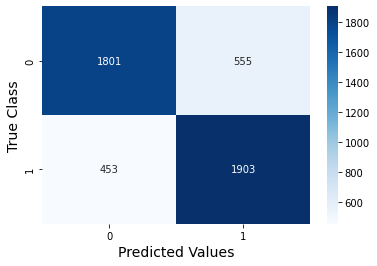

In [582]:
TP, TN, FP, FN, y_pred = matriz_confusao(resultados_sm, X_train_refinado, y_train_under)

#### Resultados Treino

In [583]:
from sklearn.metrics import roc_auc_score
from scipy import stats

acuracia_train = (TP+TN) / (TP+FP+TN+FN)
especificidade_train = TN / (TN + FP)
sensibilidade_train = TP / (TP + FN) #Recall

y_proba_train = resultados_sm.predict(X_train_refinado)
rocauc_train = roc_auc_score(y_train_under, y_proba_train) 

df_metrics['Modelo'].append('Logistic Regression')
df_metrics['Tipo'].append('Train')
df_metrics['Acurácia'].append(acuracia_train)
df_metrics['Especificidade'].append(especificidade_train)
df_metrics['Sensibilidade'].append(sensibilidade_train)
df_metrics['roc_auc'].append(rocauc_train)

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033


### Avaliando na base de Teste

#### Matriz de Confusão Teste

True Positive:  488
True Negative:  3730
False Positive:  1187
False Negative:  104


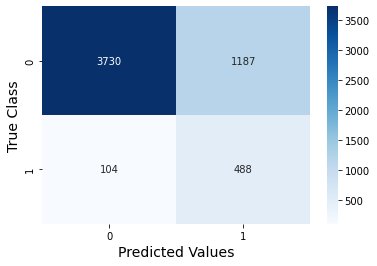

In [584]:
X_test_const = sm.add_constant(X_test_transformado)

TP, TN, FP, FN, y_pred_test = matriz_confusao(resultados_sm, X_test_const[vars_refinadas], y_test)

#### Resultados Teste

In [585]:
acuracia_test = (TP+TN) / (TP+FP+TN+FN)
especificidade_test = TN / (TN + FP)
sensibilidade_test = TP / (TP + FN) #Recall

y_proba_test = resultados_sm.predict(X_test_const[vars_refinadas])
rocauc_test = roc_auc_score(y_test, y_proba_test) 

df_metrics['Modelo'].append('Logistic Regression')
df_metrics['Tipo'].append('Test')
df_metrics['Acurácia'].append(acuracia_test)
df_metrics['Especificidade'].append(especificidade_test)
df_metrics['Sensibilidade'].append(sensibilidade_test)
df_metrics['roc_auc'].append(rocauc_test)

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723


## Árvore de Decisão

In [586]:
y_train_under.value_counts(dropna=False, normalize =True).round(2)

1    0.5
0    0.5
Name: FREQ_GRADUACAO, dtype: float64

In [587]:
X_train_under.shape, y_train_under.shape, X_test.shape, y_test.shape

((4712, 17), (4712,), (5509, 17), (5509,))

### Criando Dummies

In [588]:
X_train_cat_ohe = ohe.fit_transform(X_train_under[cat_vars])
X_test_cat_ohe  = ohe.transform(X_test[cat_vars])

In [589]:
X_train_cat_ohe.shape, y_train_under.shape, X_test_cat_ohe.shape, y_test.shape

((4712, 43), (4712,), (5509, 43), (5509,))

In [590]:
X_train_cat_ohe

,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4708,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4709,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
4710,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [591]:
X_test_cat_ohe

,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
174571,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
145900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
26625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
18353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
85304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16026,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
59719,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
22892,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
16109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


### Reconstruindo a base de Treino e Teste

In [592]:
# realinhando os índices das tabelas
X_train_num = X_train_under[num_vars].set_index(X_train_under.index)
X_test_num  = X_test[num_vars].set_index(X_test.index)

X_train_cat_ohe = X_train_cat_ohe.set_index(X_train_under.index)
X_test_cat_ohe = X_test_cat_ohe.set_index(X_test.index)

In [593]:
X_train_transformado = pd.concat([X_train_num, X_train_cat_ohe], axis='columns')
X_train_transformado

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
0,41,1,1,1.0,1.0,1.0,1.0,1.0,16,12908.74,1854.965833,151.335167,218.328500,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,46,0,0,1.0,1.0,1.0,0.0,1.0,12,10306.91,2392.216458,159.833333,107.295278,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,42,1,0,1.0,1.0,1.0,1.0,3.0,12,9817.64,2072.217500,523.100278,204.631944,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,34,0,0,1.0,1.0,0.0,1.0,0.0,14,4348.22,648.227917,198.303889,64.180694,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
4,33,1,1,1.0,1.0,0.0,0.0,1.0,12,7152.24,1439.426875,374.184375,270.858542,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,48,0,0,1.0,1.0,1.0,2.0,2.0,13,2371.00,375.285972,85.236111,19.880139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4708,23,0,1,1.0,1.0,0.0,1.0,0.0,13,4298.00,1458.753333,434.241944,45.862500,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4709,22,0,1,1.0,1.0,3.0,1.0,2.0,12,8882.84,1216.637546,202.456667,125.675648,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
4710,35,1,1,1.0,1.0,2.0,1.0,1.0,16,26136.34,4779.504167,580.036458,1745.802708,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [594]:
X_train_num

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
0,41,1,1,1.0,1.0,1.0,1.0,1.0,16,12908.74,1854.965833,151.335167,218.328500
1,46,0,0,1.0,1.0,1.0,0.0,1.0,12,10306.91,2392.216458,159.833333,107.295278
2,42,1,0,1.0,1.0,1.0,1.0,3.0,12,9817.64,2072.217500,523.100278,204.631944
3,34,0,0,1.0,1.0,0.0,1.0,0.0,14,4348.22,648.227917,198.303889,64.180694
4,33,1,1,1.0,1.0,0.0,0.0,1.0,12,7152.24,1439.426875,374.184375,270.858542
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,48,0,0,1.0,1.0,1.0,2.0,2.0,13,2371.00,375.285972,85.236111,19.880139
4708,23,0,1,1.0,1.0,0.0,1.0,0.0,13,4298.00,1458.753333,434.241944,45.862500
4709,22,0,1,1.0,1.0,3.0,1.0,2.0,12,8882.84,1216.637546,202.456667,125.675648
4710,35,1,1,1.0,1.0,2.0,1.0,1.0,16,26136.34,4779.504167,580.036458,1745.802708


In [595]:
X_train_cat_ohe

,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4708,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4709,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
4710,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [596]:
X_test_transformado = pd.concat([X_test_num, X_test_cat_ohe], axis='columns')
X_test_transformado

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
174571,20,1,0,1.0,1.0,0.0,0.0,1.0,12,2277.01,2247.560833,409.286667,82.319167,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
145900,18,1,0,1.0,1.0,0.0,0.0,1.0,12,11242.53,2620.690347,172.718542,189.943125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
26625,26,0,0,1.0,1.0,0.0,0.0,1.0,13,5454.14,764.510238,232.678095,10.605952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
18353,47,1,0,1.0,1.0,0.0,1.0,1.0,12,6059.62,1329.290625,194.057917,91.094583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
85304,50,1,0,1.0,1.0,0.0,0.0,1.0,12,2738.01,1284.188333,226.555000,101.270000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16026,54,0,1,1.0,1.0,1.0,2.0,0.0,16,11443.45,3955.333611,374.724583,1766.390000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
59719,56,1,0,1.0,1.0,1.0,0.0,1.0,12,6318.71,2169.016944,497.608333,10.741389,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0
22892,41,1,0,1.0,1.0,1.0,0.0,1.0,12,2922.36,939.528611,98.745833,43.786389,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0
16109,46,1,0,1.0,1.0,0.0,0.0,1.0,12,7264.02,1305.340463,206.492639,29.830972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


### Rodando uma Árvore de Decisão

In [597]:
# importando o módulo tree para árvores de decisão
from sklearn import tree

# instanciando um árvore de decisão
dt = tree.DecisionTreeClassifier(max_depth = 3, random_state = 42)

In [598]:
dt.fit(X_train_transformado, y_train_under)

DecisionTreeClassifier(max_depth=3, random_state=42)

### Avaliando na base de Treino

#### Matriz de Confusão Treino

True Positive:  1920
True Negative:  1939
False Positive:  417
False Negative:  436


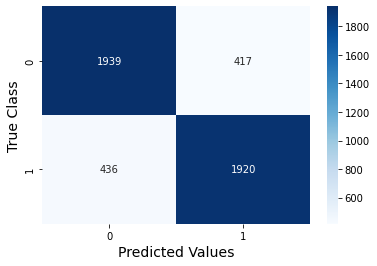

In [599]:
TP, TN, FP, FN, y_pred = matriz_confusao(dt, X_train_transformado, y_train_under)

#### Resultados Treino

In [600]:
resultados_arvores(TP, TN, FP, FN, y_pred, y_train_under, dt, X_train_transformado, 'Decision Tree', 'Train')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691


### Avaliando na base de Teste

#### Matriz de Confusão Teste

True Positive:  477
True Negative:  4004
False Positive:  913
False Negative:  115


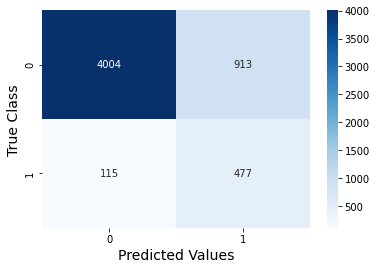

In [601]:
TP, TN, FP, FN, y_pred_test = matriz_confusao(dt, X_test_transformado, y_test)

#### Resultados Teste

In [602]:
resultados_arvores(TP, TN, FP, FN, y_pred_test, y_test, dt, X_test_transformado, 'Decision Tree', 'Test')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681


### Plotando a árvore

In [603]:
print(tree.export_text(dt, feature_names=X_train_transformado.columns.to_list()))

|--- ANOS_ESTUDO <= 12.50
|   |--- IDADE <= 22.50
|   |   |--- IDADE <= 19.50
|   |   |   |--- class: 1
|   |   |--- IDADE >  19.50
|   |   |   |--- class: 0
|   |--- IDADE >  22.50
|   |   |--- IDADE <= 40.50
|   |   |   |--- class: 0
|   |   |--- IDADE >  40.50
|   |   |   |--- class: 0
|--- ANOS_ESTUDO >  12.50
|   |--- IDADE <= 35.50
|   |   |--- ANOS_ESTUDO <= 15.50
|   |   |   |--- class: 1
|   |   |--- ANOS_ESTUDO >  15.50
|   |   |   |--- class: 1
|   |--- IDADE >  35.50
|   |   |--- IDADE <= 52.50
|   |   |   |--- class: 1
|   |   |--- IDADE >  52.50
|   |   |   |--- class: 0



In [604]:
#!pip install pydot

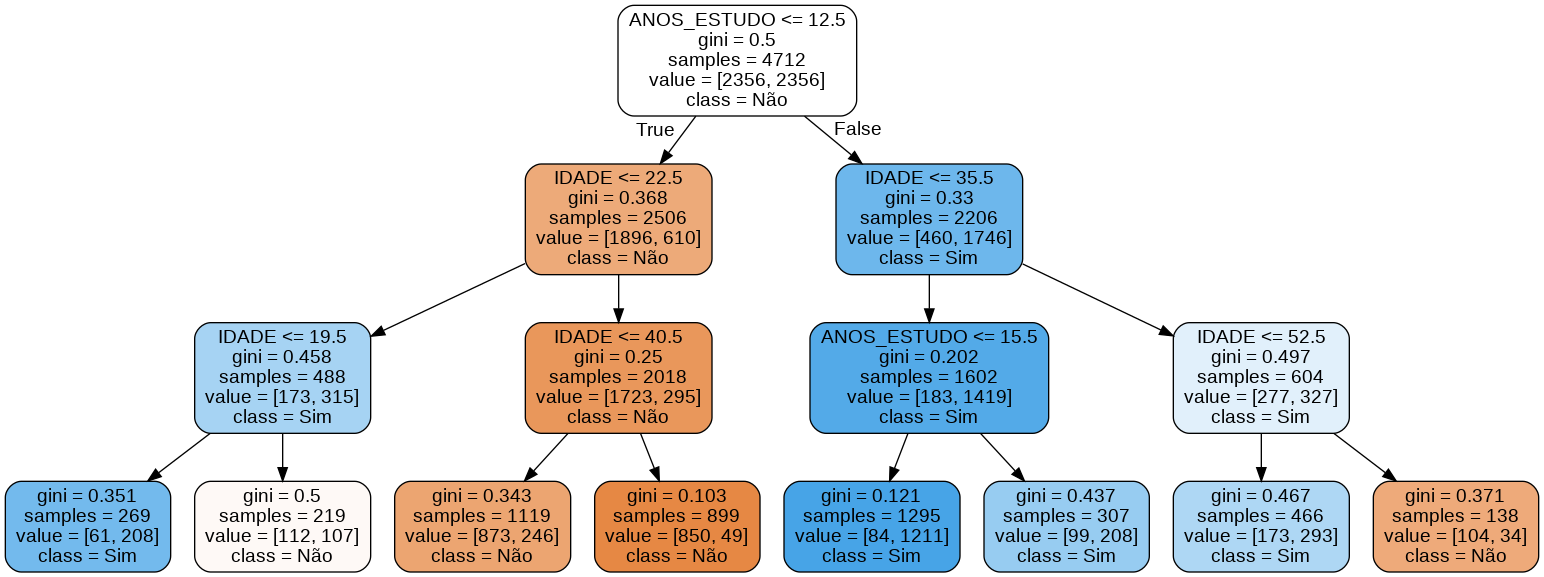

In [605]:
tree.export_graphviz(dt, feature_names=X_train_transformado.columns, class_names=['Não', 'Sim'], 
                     filled=True, rounded=True, out_file='tree.dot')

!dot -Tpng tree.dot -o tree.png

from IPython.display import Image

Image('tree.png')

### Interpretando a Árvore

In [606]:
type(y_test), type(y_pred_test)

(pandas.core.series.Series, numpy.ndarray)

In [607]:
y_test_2 = y_test.copy()

y_test_2.name = 'Target'
y_test_2 = y_test_2.reset_index()
y_test_2 = y_test_2.drop('index', axis = 1)
#y_test = y_test.drop('level_0', axis = 1)
y_test_2

,Target
0,0
1,0
2,0
3,0
4,0
...,...
5504,0
5505,0
5506,0
5507,0


In [608]:
y_pred_test_2 = y_pred_test.copy()

y_pred_test_2 = pd.Series(y_pred_test_2, name='Predito')
y_pred_test_2 = y_pred_test_2.reset_index()
y_pred_test_2 = y_pred_test_2.drop('index', axis = 1)
#y_pred_test_2 = y_pred_test_2.drop('level_0', axis = 1)
type(y_pred_test_2)

pandas.core.frame.DataFrame

In [609]:
y_pred_test_2

,Predito
0,0
1,1
2,1
3,0
4,0
...,...
5504,0
5505,0
5506,0
5507,0


In [610]:
X_test_2 = X_test.copy()

X_test_2 = X_test_2.reset_index()
X_test_2 = X_test_2.drop('index', axis = 1)
X_test_2

,UF,ESTRATO_POF,COR_RACA,COMPOSICAO,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO
0,DF,Urbano - Regiao Metropolitana,Branca,Um adulto sem criança,20,1,0,1.0,1.0,0.0,0.0,1.0,12,2277.01,2247.560833,409.286667,82.319167
1,SC,Urbano - Demais,Branca,Mais de um adulto com ao menos uma criança,18,1,0,1.0,1.0,0.0,0.0,1.0,12,11242.53,2620.690347,172.718542,189.943125
2,TO,Rural,Branca,Mais de um adulto com ao menos uma criança,26,0,0,1.0,1.0,0.0,0.0,1.0,13,5454.14,764.510238,232.678095,10.605952
3,PA,Urbano - Capital,Parda,Mais de um adulto sem criança,47,1,0,1.0,1.0,0.0,1.0,1.0,12,6059.62,1329.290625,194.057917,91.094583
4,BA,Urbano - Demais,Parda,Mais de um adulto sem criança,50,1,0,1.0,1.0,0.0,0.0,1.0,12,2738.01,1284.188333,226.555000,101.270000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5504,PA,Urbano - Demais,Branca,Mais de um adulto sem criança,54,0,1,1.0,1.0,1.0,2.0,0.0,16,11443.45,3955.333611,374.724583,1766.390000
5505,PB,Urbano - Capital,Amarela,Mais de um adulto sem criança,56,1,0,1.0,1.0,1.0,0.0,1.0,12,6318.71,2169.016944,497.608333,10.741389
5506,PA,Urbano - Capital,Parda,Mais de um adulto com ao menos uma criança,41,1,0,1.0,1.0,1.0,0.0,1.0,12,2922.36,939.528611,98.745833,43.786389
5507,PA,Urbano - Capital,Branca,"Um ou mais idosos, com ao menos um adulto, com...",46,1,0,1.0,1.0,0.0,0.0,1.0,12,7264.02,1305.340463,206.492639,29.830972


In [611]:
df_test_final = pd.concat([X_test_2, y_test_2, y_pred_test_2], axis='columns')
df_test_final

,UF,ESTRATO_POF,COR_RACA,COMPOSICAO,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO,Target,Predito
0,DF,Urbano - Regiao Metropolitana,Branca,Um adulto sem criança,20,1,0,1.0,1.0,0.0,0.0,1.0,12,2277.01,2247.560833,409.286667,82.319167,0,0
1,SC,Urbano - Demais,Branca,Mais de um adulto com ao menos uma criança,18,1,0,1.0,1.0,0.0,0.0,1.0,12,11242.53,2620.690347,172.718542,189.943125,0,1
2,TO,Rural,Branca,Mais de um adulto com ao menos uma criança,26,0,0,1.0,1.0,0.0,0.0,1.0,13,5454.14,764.510238,232.678095,10.605952,0,1
3,PA,Urbano - Capital,Parda,Mais de um adulto sem criança,47,1,0,1.0,1.0,0.0,1.0,1.0,12,6059.62,1329.290625,194.057917,91.094583,0,0
4,BA,Urbano - Demais,Parda,Mais de um adulto sem criança,50,1,0,1.0,1.0,0.0,0.0,1.0,12,2738.01,1284.188333,226.555000,101.270000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5504,PA,Urbano - Demais,Branca,Mais de um adulto sem criança,54,0,1,1.0,1.0,1.0,2.0,0.0,16,11443.45,3955.333611,374.724583,1766.390000,0,0
5505,PB,Urbano - Capital,Amarela,Mais de um adulto sem criança,56,1,0,1.0,1.0,1.0,0.0,1.0,12,6318.71,2169.016944,497.608333,10.741389,0,0
5506,PA,Urbano - Capital,Parda,Mais de um adulto com ao menos uma criança,41,1,0,1.0,1.0,1.0,0.0,1.0,12,2922.36,939.528611,98.745833,43.786389,0,0
5507,PA,Urbano - Capital,Branca,"Um ou mais idosos, com ao menos um adulto, com...",46,1,0,1.0,1.0,0.0,0.0,1.0,12,7264.02,1305.340463,206.492639,29.830972,0,0


Filtrando todo mundo de um nó da árvore vermelho

In [612]:
(
    df_test_final
    .query('ANOS_ESTUDO <= 12.5 & IDADE > 22.5 & IDADE > 40.5')
    ['Predito'].value_counts(dropna=False)
)

0    1751
Name: Predito, dtype: int64

COR VERMELHA NA ÁRVORE É PROBABILIDADE BAIXA, TODO MUNDO FICOU COM 0

Filtrando todo mundo de um nó da árvore azul

In [613]:
(
    df_test_final
    .query('ANOS_ESTUDO > 12.5 & IDADE <= 35.5 & ANOS_ESTUDO <= 15.5')
    ['Predito'].value_counts(dropna=False)
)


1    475
Name: Predito, dtype: int64

COR AZUL NA ÁRVORE É PROBABILIDADE ALTA, TODO MUNDO FICOU COM 1

## Machine Learning

### SVM

#### Rodando uma SVM

In [614]:
X_train_transformado.shape, y_train_under.shape

((4712, 56), (4712,))

In [615]:
from sklearn.svm import SVC

svm = SVC(random_state=42, probability=True)

In [616]:
svm.fit(X_train_transformado, y_train_under)

SVC(probability=True, random_state=42)

#### Avaliando na base de Treino

##### Matriz de Confusão Treino

True Positive:  1167
True Negative:  1547
False Positive:  809
False Negative:  1189


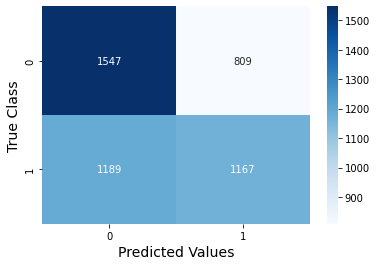

In [617]:
TP, TN, FP, FN, y_pred = matriz_confusao(svm, X_train_transformado, y_train_under)

##### Resultados Treino

In [618]:
resultados_arvores(TP, TN, FP, FN, y_pred, y_train_under, svm, X_train_transformado, 'SVM', 'Train')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883


#### Avaliando na base de Teste

##### Matriz de Confusão Teste

True Positive:  283
True Negative:  3080
False Positive:  1837
False Negative:  309


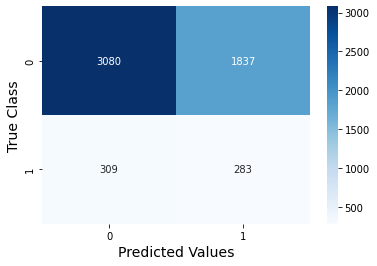

In [619]:
TP, TN, FP, FN, y_pred_test = matriz_confusao(svm, X_test_transformado, y_test)

##### Resultados Teste

In [620]:
resultados_arvores(TP, TN, FP, FN, y_pred_test, y_test, svm, X_test_transformado, 'SVM', 'Test')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695


### Random Forest (rf)

#### Rodando uma Random Forest

In [621]:
X_train_transformado.shape, y_train_under.shape

((4712, 56), (4712,))

In [622]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 3, random_state=42)

In [623]:
rf.fit(X_train_transformado, y_train_under)

RandomForestClassifier(max_depth=3, random_state=42)

#### Avaliando na base de Treino

##### Matriz de Confusão Treino

True Positive:  1911
True Negative:  1869
False Positive:  487
False Negative:  445


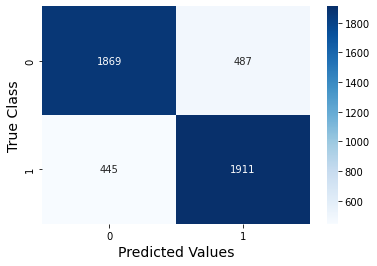

In [624]:
TP, TN, FP, FN, y_pred = matriz_confusao(rf, X_train_transformado, y_train_under)

##### Resultados Treino

In [625]:
resultados_arvores(TP, TN, FP, FN, y_pred, y_train_under, rf, X_train_transformado, 'Random Forest', 'Train')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933


#### Avaliando na base de Teste

##### Matriz de Confusão Teste

True Positive:  473
True Negative:  3872
False Positive:  1045
False Negative:  119


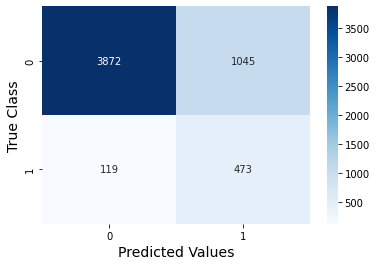

In [626]:
TP, TN, FP, FN, y_pred_test = matriz_confusao(rf, X_test_transformado, y_test)

##### Resultados Teste

In [627]:
resultados_arvores(TP, TN, FP, FN, y_pred_test, y_test, rf, X_test_transformado, 'Random Forest', 'Test')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427


### Gradient Boosting (gb)

#### Rodando um Gradient Boosting

In [628]:
X_train_transformado.shape, y_train_under.shape

((4712, 56), (4712,))

In [629]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=3, random_state=42)

In [630]:
gb.fit(X_train_transformado, y_train_under)

GradientBoostingClassifier(random_state=42)

#### Avaliando na base de Treino

##### Matriz de Confusão Treino

True Positive:  1976
True Negative:  2064
False Positive:  292
False Negative:  380


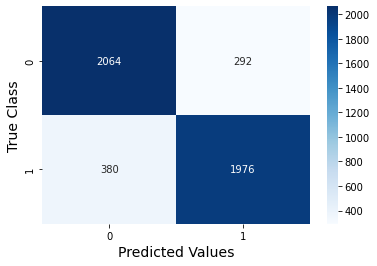

In [631]:
TP, TN, FP, FN, y_pred = matriz_confusao(gb, X_train_transformado, y_train_under)

##### Resultados Treino

In [632]:
resultados_arvores(TP, TN, FP, FN, y_pred, y_train_under, gb, X_train_transformado, 'Gradient Boosting', 'Train')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788


#### Avaliando na base de Teste

##### Matriz de Confusão Teste

True Positive:  472
True Negative:  4137
False Positive:  780
False Negative:  120


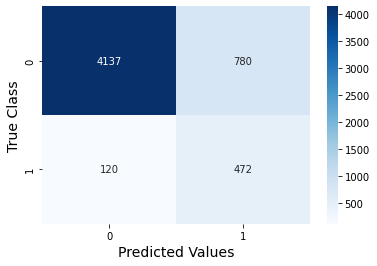

In [633]:
TP, TN, FP, FN, y_pred_test = matriz_confusao(gb, X_test_transformado, y_test)

##### Resultados Teste

In [634]:
resultados_arvores(TP, TN, FP, FN, y_pred_test, y_test, gb, X_test_transformado, 'Gradient Boosting', 'Test')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203


### Xtreme Gradient Boosting (XGBoost)

#### Rodando um XGBoost

In [635]:
X_train_transformado.shape, y_train_under.shape

((4712, 56), (4712,))

In [636]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=3, random_state=42)

In [637]:
xgb.fit(X_train_transformado, y_train_under)

XGBClassifier(random_state=42)

#### Avaliando na base de Treino

##### Matriz de Confusão Treino

True Positive:  1974
True Negative:  2049
False Positive:  307
False Negative:  382


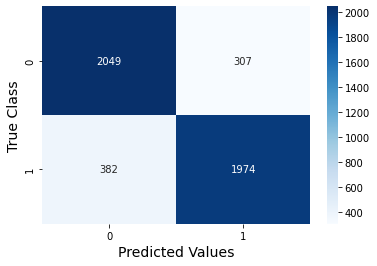

In [638]:
TP, TN, FP, FN, y_pred = matriz_confusao(xgb, X_train_transformado, y_train_under)

##### Resultados Treino

In [639]:
resultados_arvores(TP, TN, FP, FN, y_pred, y_train_under, xgb, X_train_transformado, 'Xtreme Gradient Boosting', 'Train')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203


#### Avaliando na base de Teste

##### Matriz de Confusão Teste

True Positive:  474
True Negative:  4115
False Positive:  802
False Negative:  118


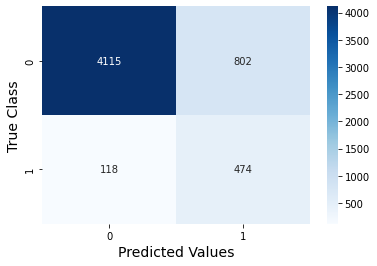

In [640]:
TP, TN, FP, FN, y_pred_test = matriz_confusao(xgb, X_test_transformado, y_test)

##### Resultados Teste

In [641]:
resultados_arvores(TP, TN, FP, FN, y_pred_test, y_test, xgb, X_test_transformado, 'Xtreme Gradient Boosting', 'Test')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203


### Light Gradient Boosting (lgbm)

#### Rodando um LGBM

In [642]:
X_train_transformado.shape, y_train_under.shape

((4712, 56), (4712,))

In [643]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(max_depth=3, random_state=42)

In [644]:
lgbm.fit(X_train_transformado, y_train_under)

LGBMClassifier(max_depth=3, random_state=42)

#### Avaliando na base de Treino

##### Matriz de Confusão Treino

True Positive:  1967
True Negative:  2048
False Positive:  308
False Negative:  389


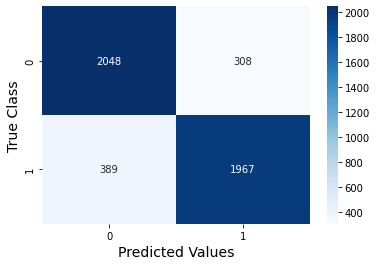

In [645]:
TP, TN, FP, FN, y_pred = matriz_confusao(lgbm, X_train_transformado, y_train_under)

##### Resultados Treino

In [646]:
resultados_arvores(TP, TN, FP, FN, y_pred, y_train_under, lgbm, X_train_transformado, 'Light Gradient Boosting', 'Train')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203


#### Avaliando na base de Teste

##### Matriz de Confusão Teste

True Positive:  477
True Negative:  4119
False Positive:  798
False Negative:  115


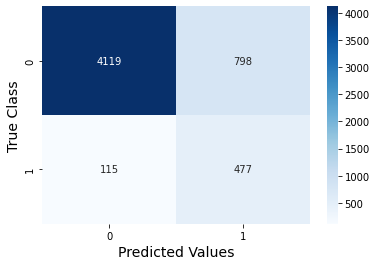

In [647]:
TP, TN, FP, FN, y_pred_test = matriz_confusao(lgbm, X_test_transformado, y_test)

##### Resultados Teste

In [648]:
resultados_arvores(TP, TN, FP, FN, y_pred_test, y_test, lgbm, X_test_transformado, 'Light Gradient Boosting', 'Test')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203


### Catboost

#### Rodando um Catboost

In [649]:
X_train_transformado.shape, y_train_under.shape

((4712, 56), (4712,))

In [650]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(max_depth=3, random_state=42)

In [651]:
catboost.fit(X_train_transformado, y_train_under)

Learning rate set to 0.019971
0:	learn: 0.6814310	total: 1.45ms	remaining: 1.44s
1:	learn: 0.6698599	total: 2.88ms	remaining: 1.44s
2:	learn: 0.6587137	total: 4.27ms	remaining: 1.42s
3:	learn: 0.6480422	total: 5.62ms	remaining: 1.4s
4:	learn: 0.6382736	total: 7.04ms	remaining: 1.4s
5:	learn: 0.6287868	total: 8.41ms	remaining: 1.39s
6:	learn: 0.6205042	total: 9.73ms	remaining: 1.38s
7:	learn: 0.6126477	total: 11.1ms	remaining: 1.37s
8:	learn: 0.6051621	total: 12.5ms	remaining: 1.37s
9:	learn: 0.5973996	total: 13.8ms	remaining: 1.37s
10:	learn: 0.5898549	total: 15.1ms	remaining: 1.36s
11:	learn: 0.5828754	total: 16.5ms	remaining: 1.36s
12:	learn: 0.5758276	total: 18ms	remaining: 1.36s
13:	learn: 0.5696531	total: 19.4ms	remaining: 1.36s
14:	learn: 0.5630644	total: 20.8ms	remaining: 1.37s
15:	learn: 0.5569797	total: 22.1ms	remaining: 1.36s
16:	learn: 0.5508385	total: 23.6ms	remaining: 1.36s
17:	learn: 0.5455640	total: 25ms	remaining: 1.36s
18:	learn: 0.5400523	total: 26.4ms	remaining: 1.36

#### Avaliando na base de Treino

##### Matriz de Confusão Treino

True Positive:  2005
True Negative:  2053
False Positive:  303
False Negative:  351


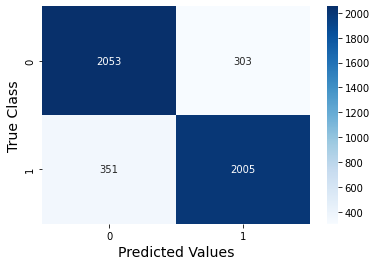

In [652]:
TP, TN, FP, FN, y_pred = matriz_confusao(catboost, X_train_transformado, y_train_under)

##### Resultados Treino

In [653]:
resultados_arvores(TP, TN, FP, FN, y_pred, y_train_under, catboost, X_train_transformado, 'Catboost', 'Train')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203


#### Avalando na base de Teste

##### Matriz de Confusão Teste

True Positive:  479
True Negative:  4106
False Positive:  811
False Negative:  113


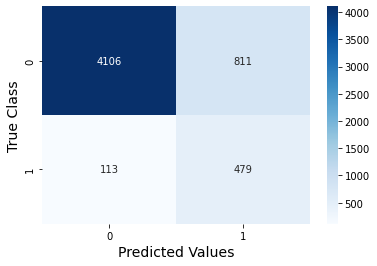

In [654]:
TP, TN, FP, FN, y_pred_test = matriz_confusao(catboost, X_test_transformado, y_test)

##### Resultados Teste

In [655]:
resultados_arvores(TP, TN, FP, FN, y_pred_test, y_test, catboost, X_test_transformado, 'Catboost', 'Test')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203


### Melhor modelo

In [656]:
df_metrics_results = pd.DataFrame(df_metrics)

Treino

In [657]:
( 
    df_metrics_results
    .query("Tipo == 'Train'")
    .sort_values(by='roc_auc', ascending=False)
)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
14,Catboost,Train,0.861205,0.871392,0.851019,0.933775
10,Xtreme Gradient Boosting,Train,0.853778,0.869694,0.837861,0.930139
12,Light Gradient Boosting,Train,0.852080,0.869270,0.834890,0.929751
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
4,SVM,Train,0.575976,0.656621,0.495331,0.608883


O melhor modelo foi o Gradient Boosting quando ordenamos pela ROC, mas o Catboost está quase igual sendo que o Catboost teve acurácia melhor. Irei com o **Catboost**

Teste

In [658]:
( 
    df_metrics_results
    .query("Tipo == 'Test'")
    .sort_values(by='roc_auc', ascending=False)
)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
15,Catboost,Test,0.832274,0.835062,0.809122,0.898233
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203
13,Light Gradient Boosting,Test,0.834271,0.837706,0.805743,0.892856
11,Xtreme Gradient Boosting,Test,0.833001,0.836892,0.800676,0.892514
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
5,SVM,Test,0.610456,0.626398,0.478041,0.582695


No Teste o melhor modelo foi o **Catboost** na ROC e foi um dos melhores em acurácia

**MELHOR MODELO: CATBOOST**

### Tentando melhorar o melhor modelo

#### StratifiedKFold

Double Check no modelo

In [659]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

Treino

In [660]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(estimator=catboost, X=X_train_transformado, y=y_train_under, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=skf, n_jobs=-1)
cat_model_results = pd.DataFrame(cv_results)

In [661]:
cat_model_results

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,3.121537,0.024928,0.825027,0.816116,0.838641,0.827225,0.912398
1,3.162035,0.023028,0.841994,0.840000,0.845339,0.842661,0.914193
2,2.829443,0.021368,0.826964,0.856481,0.785563,0.819491,0.903048
3,2.996809,0.042176,0.831210,0.836207,0.823779,0.829947,0.907966
4,1.356476,0.012414,0.829087,0.835498,0.819533,0.827438,0.902047


In [662]:
cat_model_results.mean()

fit_time          2.693260
score_time        0.024783
test_accuracy     0.830856
test_precision    0.836860
test_recall       0.822571
test_f1           0.829352
test_roc_auc      0.907930
dtype: float64

Utilizando SKF os valores ficam piores que os obtidos anteriormente no treino

#### GridSearch

**RODEI APENAS UMA VEZ PARA VER O MELHOR MODELO, ESSA LINHA DE BAIXO FOI O MELHOR MODELO**

In [667]:
tuned_catboost = CatBoostClassifier(max_depth=3, learning_rate = 0.03, l2_leaf_reg = 7, random_state=42)

tuned_catboost.fit(X_train_transformado, y_train_under)

0:	learn: 0.6756621	total: 4.94ms	remaining: 4.94s
1:	learn: 0.6590922	total: 7.7ms	remaining: 3.84s
2:	learn: 0.6431657	total: 10.7ms	remaining: 3.57s
3:	learn: 0.6281479	total: 14.2ms	remaining: 3.55s
4:	learn: 0.6152717	total: 17.8ms	remaining: 3.53s
5:	learn: 0.6035837	total: 21.3ms	remaining: 3.53s
6:	learn: 0.5931624	total: 25ms	remaining: 3.54s
7:	learn: 0.5830797	total: 28.8ms	remaining: 3.57s
8:	learn: 0.5739935	total: 32.6ms	remaining: 3.59s
9:	learn: 0.5641757	total: 37.1ms	remaining: 3.67s
10:	learn: 0.5544293	total: 39.8ms	remaining: 3.58s
11:	learn: 0.5453307	total: 43.4ms	remaining: 3.57s
12:	learn: 0.5376693	total: 46.8ms	remaining: 3.55s
13:	learn: 0.5297698	total: 50.3ms	remaining: 3.54s
14:	learn: 0.5227269	total: 53.9ms	remaining: 3.54s
15:	learn: 0.5168957	total: 70.2ms	remaining: 4.32s
16:	learn: 0.5111573	total: 86.5ms	remaining: 5s
17:	learn: 0.5062424	total: 89.1ms	remaining: 4.86s
18:	learn: 0.5004247	total: 92.8ms	remaining: 4.79s
19:	learn: 0.4952021	total: 

In [ ]:
# from sklearn.model_selection import GridSearchCV

# #coloca o model__ para falar onde o gridsearch irá aplicar o modelo
# grid_parametros = {
#     'max_depth': [2, 3, 4, 5, 6, 7]
#     ,'learning_rate': [0.03, 0.1]
#     ,'l2_leaf_reg': [1, 3, 5, 7, 9]
# }

# grid_search = GridSearchCV(estimator=catboost, param_grid=grid_parametros, scoring='roc_auc', cv=skf, n_jobs=-1, refit=True, verbose=1)
# grid_search.fit(X_train_transformado, y_train_under)

In [664]:
# # retorna a melhor combinação de hiperparâmetros
# best_params = grid_search.best_params_
# best_params

{'l2_leaf_reg': 7, 'learning_rate': 0.03, 'max_depth': 3}

In [665]:
# # retorna o melhor score, nesse caso a roc-auc média usando um cv=5
# best_score = grid_search.best_score_
# best_score

0.9070604698631689

In [666]:
# # retorna o melhor modelo do grid
# tuned_catboost = grid_search.best_estimator_

##### Avaliando na base de Treino

###### Matriz de Confusão Treino

True Positive:  2026
True Negative:  2074
False Positive:  282
False Negative:  330


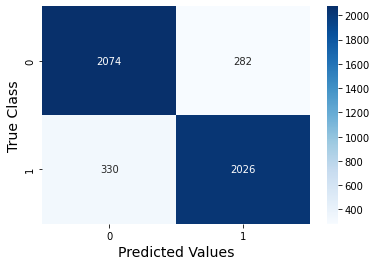

In [668]:
TP, TN, FP, FN, y_pred = matriz_confusao(tuned_catboost, X_train_transformado, y_train_under)

###### Resultados Treino

In [669]:
resultados_arvores(TP, TN, FP, FN, y_pred, y_train_under, tuned_catboost, X_train_transformado, 'Tuned Catboost', 'Train')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203


##### Avaliando na base de Teste

###### Matriz de Confusão Teste

True Positive:  480
True Negative:  4111
False Positive:  806
False Negative:  112


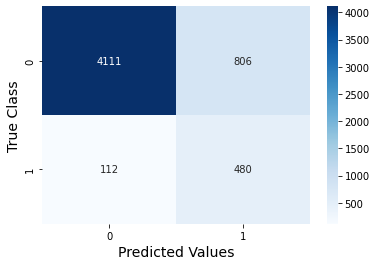

In [670]:
TP, TN, FP, FN, y_pred_test = matriz_confusao(tuned_catboost, X_test_transformado, y_test)

###### Resultados Teste

In [671]:
resultados_arvores(TP, TN, FP, FN, y_pred_test, y_test, tuned_catboost, X_test_transformado, 'Tuned Catboost', 'Test')

pd.DataFrame(df_metrics)

,Modelo,Tipo,Acurácia,Especificidade,Sensibilidade,roc_auc
0,Logistic Regression,Train,0.786078,0.764431,0.807725,0.852033
1,Logistic Regression,Test,0.765656,0.758593,0.824324,0.843723
2,Decision Tree,Train,0.818973,0.823005,0.814941,0.884691
3,Decision Tree,Test,0.813396,0.814318,0.805743,0.872681
4,SVM,Train,0.575976,0.656621,0.495331,0.608883
5,SVM,Test,0.610456,0.626398,0.478041,0.582695
6,Random Forest,Train,0.802207,0.793294,0.811121,0.886933
7,Random Forest,Test,0.788709,0.787472,0.798986,0.868427
8,Gradient Boosting,Train,0.857385,0.876061,0.838710,0.933788
9,Gradient Boosting,Test,0.836631,0.841367,0.797297,0.894203


O Tuned Catboost melhorou no treino, mas quando chegou no teste não apresentou melhora. **De qualquer forma vou utilizar o Tuned Catboost**

### Shap Values

In [672]:
#SHAP
try: 
    import shap
except: 
    !pip install shap
    import shap

     |████████████████████████████████| 564 kB 13.2 MB/s 


In [673]:
X_test_transformado.head()

,IDADE,SEXO_M,TEM_PLANO_SAUDE,TRABALHOU_ULT_12M,GASTOS_SEM_RENDA,QTD_CARTAOCRED,QTD_CONTACORR,QTD_CONTAPOUP,ANOS_ESTUDO,RENDA_TOTAL,PC_RENDA_DISP,PC_RENDA_NAO_MONET,PC_DEDUCAO,UF_PE,UF_MT,UF_MG,UF_MS,UF_DF,UF_CE,UF_GO,UF_RS,UF_PR,UF_SE,UF_RN,UF_RJ,UF_SP,UF_ES,UF_RR,UF_PI,UF_PB,UF_MA,UF_BA,UF_RO,UF_SC,UF_PA,UF_TO,UF_AC,UF_AM,UF_AP,UF_AL,ESTRATO_POF_Urbano - Demais,ESTRATO_POF_Rural,ESTRATO_POF_Urbano - Capital,ESTRATO_POF_Urbano - Regiao Metropolitana,COR_RACA_Parda,COR_RACA_Preta,COR_RACA_Branca,COR_RACA_Amarela,COR_RACA_Indígena,COR_RACA_Sem declaração,COMPOSICAO_Mais de um adulto com ao menos uma criança,COMPOSICAO_Mais de um adulto sem criança,"COMPOSICAO_Um ou mais idosos, com ao menos um adulto, com ou sem crianças",COMPOSICAO_Um adulto sem criança,COMPOSICAO_Um ou mais idosos com ou sem crianças,COMPOSICAO_Um adulto com ao menos uma criança
174571,20,1,0,1.0,1.0,0.0,0.0,1.0,12,2277.01,2247.560833,409.286667,82.319167,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
145900,18,1,0,1.0,1.0,0.0,0.0,1.0,12,11242.53,2620.690347,172.718542,189.943125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
26625,26,0,0,1.0,1.0,0.0,0.0,1.0,13,5454.14,764.510238,232.678095,10.605952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
18353,47,1,0,1.0,1.0,0.0,1.0,1.0,12,6059.62,1329.290625,194.057917,91.094583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
85304,50,1,0,1.0,1.0,0.0,0.0,1.0,12,2738.01,1284.188333,226.555000,101.270000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [674]:
import shap
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_test_transformado)
shap_values

array([[ 1.77272430e+00, -2.71390493e-02, -2.48310526e-02, ...,
        -1.96062780e-03,  2.14844209e-04, -8.97733060e-04],
       [ 2.45192892e+00, -2.69046672e-02, -2.58226084e-02, ...,
         1.12091351e-05,  6.07186723e-04, -8.69326905e-04],
       [ 4.73752066e-01,  2.48789517e-02, -1.75476494e-02, ...,
         1.12091351e-05,  9.36220824e-04, -1.68871338e-03],
       ...,
       [-7.00452655e-01, -2.55949926e-02, -3.05993628e-02, ...,
         5.72711804e-05,  5.53768520e-04, -1.47205661e-03],
       [-1.22356686e+00, -3.04732445e-02, -1.88831657e-02, ...,
         3.12245164e-04,  5.76819831e-04, -1.08963622e-03],
       [ 1.38812311e+00, -2.76684155e-02, -2.57391760e-02, ...,
        -2.43764849e-04,  5.53768520e-04, -1.15594119e-03]])

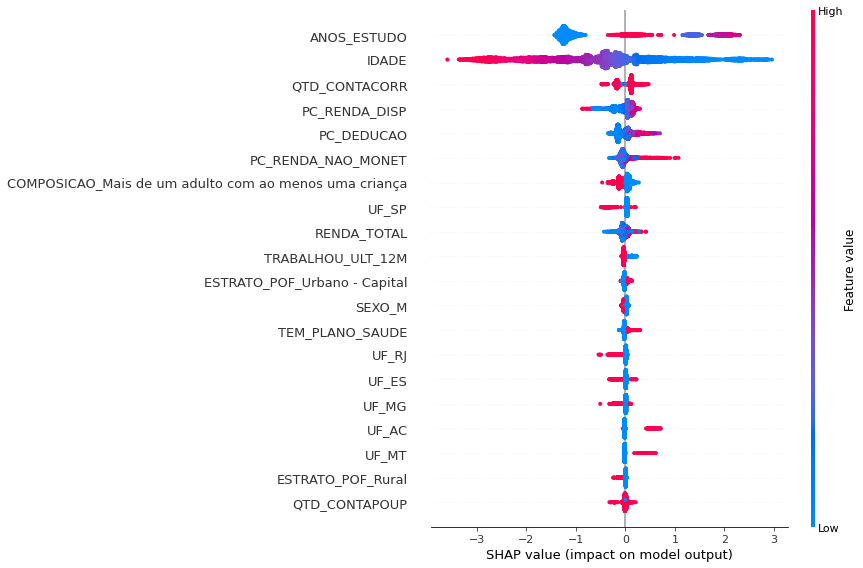

In [676]:
# plotando o shap summary plot
shap.summary_plot(shap_values, X_test_transformado, plot_type='dot')

As variáveis que mais discriminaram no modelo foram:
Tempo de Estudo: Pessoas com mais tempo de estudo tem mais 

*   **Tempo de Estudo**: Pessoas com mais tempo de estudo tem mais probabilidade, geralmente essas pessoas começaram um curso de graduação no passado mas não terminara 
*   **Idade**: Pessoas mais novas possuem mais probabilidade de cursar uma graduação